In [1]:
!pip install torch torch-geometric

In [2]:
!pip install h5py

In [3]:
!pip install torchviz

# Load Graph

## Remove nodes with zero feature

In [4]:
import numpy as np
import h5py

def remove_zero_feature_nodes_across_graphs(filename):
    #node_to_check = 20130
    with h5py.File(filename, 'r') as f:
        graph_data = f['graph_data']
        num_graphs = graph_data.shape[1]

        zero_feature_candidates = None

        for i in range(num_graphs):
            graph_ref = graph_data[0, i]
            graph = f[graph_ref]
            node_features_raw = np.array(graph['node_features']).T 

            relevant_features = node_features_raw[:, 1:]

            # Adjust for one-based indexing
            #node_to_check_index = node_to_check - 1  # Convert to zero-based index

            # Print the features for node 20130 if it exists in this graph
            #if node_to_check_index < node_features_raw.shape[0]:
             #   print(f"Graph {i}, Node {node_to_check} features: {relevant_features[node_to_check_index]}")

            zero_feature_nodes = set(np.where(~relevant_features.any(axis=1))[0])  # Nodes with all zeros
            zero_feature_nodes = {index + 1 for index in zero_feature_nodes}  # Back to one-based indexing

            if zero_feature_candidates is None:
                zero_feature_candidates = zero_feature_nodes
            else:
                zero_feature_candidates &= zero_feature_nodes 

        zero_feature_nodes = sorted(zero_feature_candidates) if zero_feature_candidates else []
        return zero_feature_nodes, graph_data

In [5]:
# Step 1: Identify and remove nodes with zero features across all graphs
filename_train_data = "train_graph_data.mat"
zero_feature_nodes_train, train_data = remove_zero_feature_nodes_across_graphs(filename_train_data)
print(f"Number of nodes with zero features: {len(zero_feature_nodes_train)}")

Number of nodes with zero features: 14070


In [6]:
filename_test_data = "test_graph_data.mat"
zero_feature_nodes_test, train_data = remove_zero_feature_nodes_across_graphs(filename_test_data)
print(f"Number of nodes with zero features: {len(zero_feature_nodes_test)}")

Number of nodes with zero features: 12638


### Additional check: any edges connected zero_feature nodes

In [10]:
import h5py
import numpy as np

def check_edges_between_zero_feature_nodes(filename, zero_feature_nodes):
    zero_feature_nodes_set = set(zero_feature_nodes)
    with h5py.File(filename, 'r') as f:
        for i in range(f['graph_data'].shape[1]):
            graph_ref = f['graph_data'][0, i]
            graph = f[graph_ref]
            edge_features = np.array(graph['edge_features']).T
            nodes1 = edge_features[:, 0]
            nodes2 = edge_features[:, 1]
            if np.any(np.isin(nodes1, zero_feature_nodes_set) | np.isin(nodes2, zero_feature_nodes_set)):
                return True
    return False

In [11]:
has_zero_feature_edges = check_edges_between_zero_feature_nodes(filename_train_data, zero_feature_nodes_train)
print(f"Are there edges between zero-feature nodes? {has_zero_feature_edges}")

Are there edges between zero-feature nodes? False


In [12]:
has_zero_feature_edges = check_edges_between_zero_feature_nodes(filename_test_data, zero_feature_nodes_test)
print(f"Are there edges between zero-feature nodes? {has_zero_feature_edges}")

Are there edges between zero-feature nodes? False


There is no edge connecting zero-feature nodes, great!

## Construct input graph

In [7]:
import torch
import os
import h5py
import numpy as np

def construct_graphs(filename, zero_feature_nodes, save_dir="graphs"):
    os.makedirs(save_dir, exist_ok=True)

    with h5py.File(filename, 'r') as f:
        graph_data = f['graph_data']
        num_graphs = graph_data.shape[1]

        for i in range(num_graphs):
            graph_ref = graph_data[0, i]
            graph = f[graph_ref]

            node_features_raw = np.array(graph['node_features']).T
            node_features_delete = np.delete(node_features_raw, zero_feature_nodes, axis=0)

            edge_features_raw = np.array(graph['edge_features']).T
            num_nodes = node_features_delete.shape[0]

            # Mapping
            max_index = node_features_raw.shape[0] + 1  # Since indices are 1-based, include the maximum possible index.
            all_indices = np.arange(1, max_index)  # Create a range starting from 1.
            remaining_indices = np.setdiff1d(all_indices, zero_feature_nodes)
            mapping = {old: new for new, old in enumerate(remaining_indices)}
            #print(mapping)
            
            ## NODE:
            num_valid_nodes = len(mapping)
            feature_dim = node_features_raw.shape[1] - 1  # Excluding the index column
            sorted_node_features = np.zeros((num_valid_nodes, feature_dim))

            # Populate the new node features array using the mapping
            for feature in node_features_raw:
              node_index = feature[0]
              if node_index in mapping:
                new_index = mapping[node_index]
                sorted_node_features[new_index] = feature[1:]  # Exclude the index column from features

            node_features = torch.tensor(sorted_node_features, dtype=torch.float32)

            ### New Edge index:
            cell1 = edge_features_raw[:, 0].astype(int)  # Node index 1
            cell2 = edge_features_raw[:, 1].astype(int)  # Node index 2
            remapped_cell1 = np.array([mapping[node] for node in cell1])
            remapped_cell2 = np.array([mapping[node] for node in cell2])
            edge_index = np.stack((remapped_cell1, remapped_cell2), axis=0)

            ### New Edge features:
            edge_attr = edge_features_raw[:, 3:] 

            ## JUNCTION LOSS:
            junction_loss_raw = np.array(graph['junction_loss']).T
            y = torch.tensor(junction_loss_raw[:,1], dtype=torch.float).view(-1, 1)  # Shape: (n_edges, 1)
            
            # Save graph to file
            processed_data = {
                "nodes": node_features,         # (num_nodes, feature_dim)
                "edge_index": edge_index,      #(2, num_edges)
                "edge_attr": edge_attr,        #(num_edges, feature_dim)
                "y": y             #  (n_edges, 1)
            }
            torch.save(processed_data, os.path.join(save_dir, f"graph_{i}.pt"))
            print(f"Graph {i} saved to {save_dir}/graph_{i}.pt")

### Testing construct_graphs function

In [26]:
import h5py
import numpy as np

# Create or update an existing .h5 file
filename = 'test_graph_data.h5'
with h5py.File(filename, 'w') as f:
    # Create a dataset simulating the graph data container
    num_graphs = 1
    graph_dtype = h5py.special_dtype(ref=h5py.Reference)
    graph_data = f.create_dataset('graph_data', (1, num_graphs), dtype=graph_dtype)

    # Example graph data
    graph_group = f.create_group('graph1')
    # Adding zero-feature nodes: Nodes 1 and 4
    node_features = np.array([
        [0, 1.0, 2.0, 1.0, 2.0],  # Node index followed by features
        [3, 2.0, 3.0, 1.0, 2.0],
        [2, 4.0, 5.0, 1.0, 2.0],
        [1, 0.0, 0.0, 0.0, 0.0],  # Zero features
        [4, 0.0, 0.0, 0.0, 0.0]   # Zero features
    ]).T
    edge_features = np.array([
        [0, 3, 0, 0.5, 0.5],  # , node1, node2, Edge index, feature1, feature2
        [3, 2, 1, 0.3, 0.7],
        [0, 2, 2, 0.2, 0.8],
    ]).T
    junction_loss = np.array([
        [0, 3],  # Edge between node0 and node1
        [3, 2]   # Edge between node1 and node2
        # No junction loss involving zero feature nodes as they will be removed
    ])

    # Adding datasets to the group
    graph_group.create_dataset('node_features', data=node_features)
    graph_group.create_dataset('edge_features', data=edge_features)
    graph_group.create_dataset('junction_loss', data=junction_loss)

    # Linking graph group in the main dataset
    graph_data[0, 0] = graph_group.ref

print("Updated mock .mat file with zero-feature nodes created.")


Updated mock .mat file with zero-feature nodes created.


In [27]:
zero_feature_nodes = [1, 4]  # Indices of nodes with zero features
save_dir = 'graphs_test'  # Directory where graphs will be saved

# Call the function
construct_graphs(filename, zero_feature_nodes, save_dir)

Graph 0 saved to graphs_test/graph_0.pt


In [28]:
import torch
# Load the saved graph
saved_graph = torch.load(f'{save_dir}/graph_0.pt')
print("Nodes:")
print(saved_graph['nodes'])
print("Edges:")
print(saved_graph['edges'])
print("Adjacency Matrix:")
print(saved_graph['adjacency'])
print("Labels:")
print(saved_graph['labels'])

Nodes:
tensor([[1., 2., 1., 2.],
        [4., 5., 1., 2.],
        [2., 3., 1., 2.]])
Edges:
tensor([[[0.0000, 0.0000],
         [0.2000, 0.8000],
         [0.5000, 0.5000]],

        [[0.2000, 0.8000],
         [0.0000, 0.0000],
         [0.3000, 0.7000]],

        [[0.5000, 0.5000],
         [0.3000, 0.7000],
         [0.0000, 0.0000]]])
Adjacency Matrix:
tensor([[0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 0.]])
Labels:
tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 1., 0.]])


/tmp/ipykernel_112420/2894248200.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_graph = torch.load(f'{save_dir}/graph_0.pt')


In [31]:
print(saved_graph['edges'].shape)

torch.Size([3, 3, 2])


### Construct graph

In [13]:
#import shutil
#shutil.rmtree("train")

In [14]:
# Step 2: Construct graphs with the remaining nodes
processed_graphs_train = construct_graphs(filename_train_data, zero_feature_nodes_train, save_dir = 'train')

Graph 0 saved to train/graph_0.pt
Graph 1 saved to train/graph_1.pt
Graph 2 saved to train/graph_2.pt
Graph 3 saved to train/graph_3.pt
Graph 4 saved to train/graph_4.pt
Graph 5 saved to train/graph_5.pt
Graph 6 saved to train/graph_6.pt
Graph 7 saved to train/graph_7.pt
Graph 8 saved to train/graph_8.pt
Graph 9 saved to train/graph_9.pt
Graph 10 saved to train/graph_10.pt
Graph 11 saved to train/graph_11.pt
Graph 12 saved to train/graph_12.pt
Graph 13 saved to train/graph_13.pt
Graph 14 saved to train/graph_14.pt
Graph 15 saved to train/graph_15.pt
Graph 16 saved to train/graph_16.pt
Graph 17 saved to train/graph_17.pt
Graph 18 saved to train/graph_18.pt
Graph 19 saved to train/graph_19.pt
Graph 20 saved to train/graph_20.pt
Graph 21 saved to train/graph_21.pt
Graph 22 saved to train/graph_22.pt
Graph 23 saved to train/graph_23.pt
Graph 24 saved to train/graph_24.pt
Graph 25 saved to train/graph_25.pt
Graph 26 saved to train/graph_26.pt
Graph 27 saved to train/graph_27.pt
Graph 28 sav

In [ ]:
processed_graphs_test = construct_graphs(filename_test_data, zero_feature_nodes_test, save_dir = 'test')

In [16]:
graph_files = [file for file in os.listdir("train") if file.endswith('.pt')]
for file in graph_files:
        graph_path = os.path.join("train", file)
        graph = torch.load(graph_path)

        print(f"File: {file}")
        print(f"  Node features dimensions: {graph['nodes'].shape}")
        print(f"  Edge index dimensions: {graph['edge_index'].shape}")
        print(f"  Edge features matrix dimensions: {graph['edge_attr'].shape}")
        print(f"  Labels dimensions: {graph['y'].shape}")
        print()
        break

File: graph_120.pt
  Node features dimensions: torch.Size([6103, 4])
  Edge index dimensions: (2, 13015)
  Edge features matrix dimensions: (13015, 2)
  Labels dimensions: torch.Size([13015, 1])



# Data Loader

In [5]:
import os
import torch
from torch_geometric.data import Data, DataLoader

def load_graphs(directory):
    graph_files = [file for file in os.listdir(directory) if file.endswith('.pt')]
    data_list = []

    for file in graph_files:
        graph_path = os.path.join(directory, file)
        graph = torch.load(graph_path)
        
        # Create a Data object from the loaded graph
        data = Data(x=torch.tensor(graph['nodes'], dtype=torch.float),
                    edge_index=torch.tensor(graph['edge_index'], dtype=torch.long),
                    edge_attr=torch.tensor(graph['edge_attr'], dtype=torch.float),
                    y=torch.tensor(graph['y'], dtype=torch.float))

        data_list.append(data)
        
        #print(f"File: {file}")
        #print(f"  Node features dimensions: {data.x.shape}")
        #print(f"  Edge index dimensions: {data.edge_index.shape}")
        #print(f"  Edge features matrix dimensions: {data.edge_attr.shape}")
        #print(f"  Labels dimensions: {data.y.shape}")
        #print()

    return data_list

train_data_list = load_graphs("train")

/tmp/ipykernel_1431/867551444.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = Data(x=torch.tensor(graph['nodes'], dtype=torch.float),
/tmp/ipykernel_1431/867551444.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(graph['y'], dtype=torch.float))


In [21]:
# Create a DataLoader for batching and shuffling the graph data
train_loader = DataLoader(train_data_list, batch_size=1, shuffle=True)

In [7]:
test_data_list = load_graphs("test")
test_loader = DataLoader(test_data_list, batch_size=1, shuffle=False)

/tmp/ipykernel_1431/867551444.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = Data(x=torch.tensor(graph['nodes'], dtype=torch.float),
/tmp/ipykernel_1431/867551444.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(graph['y'], dtype=torch.float))


# Exploratory Data Analysis

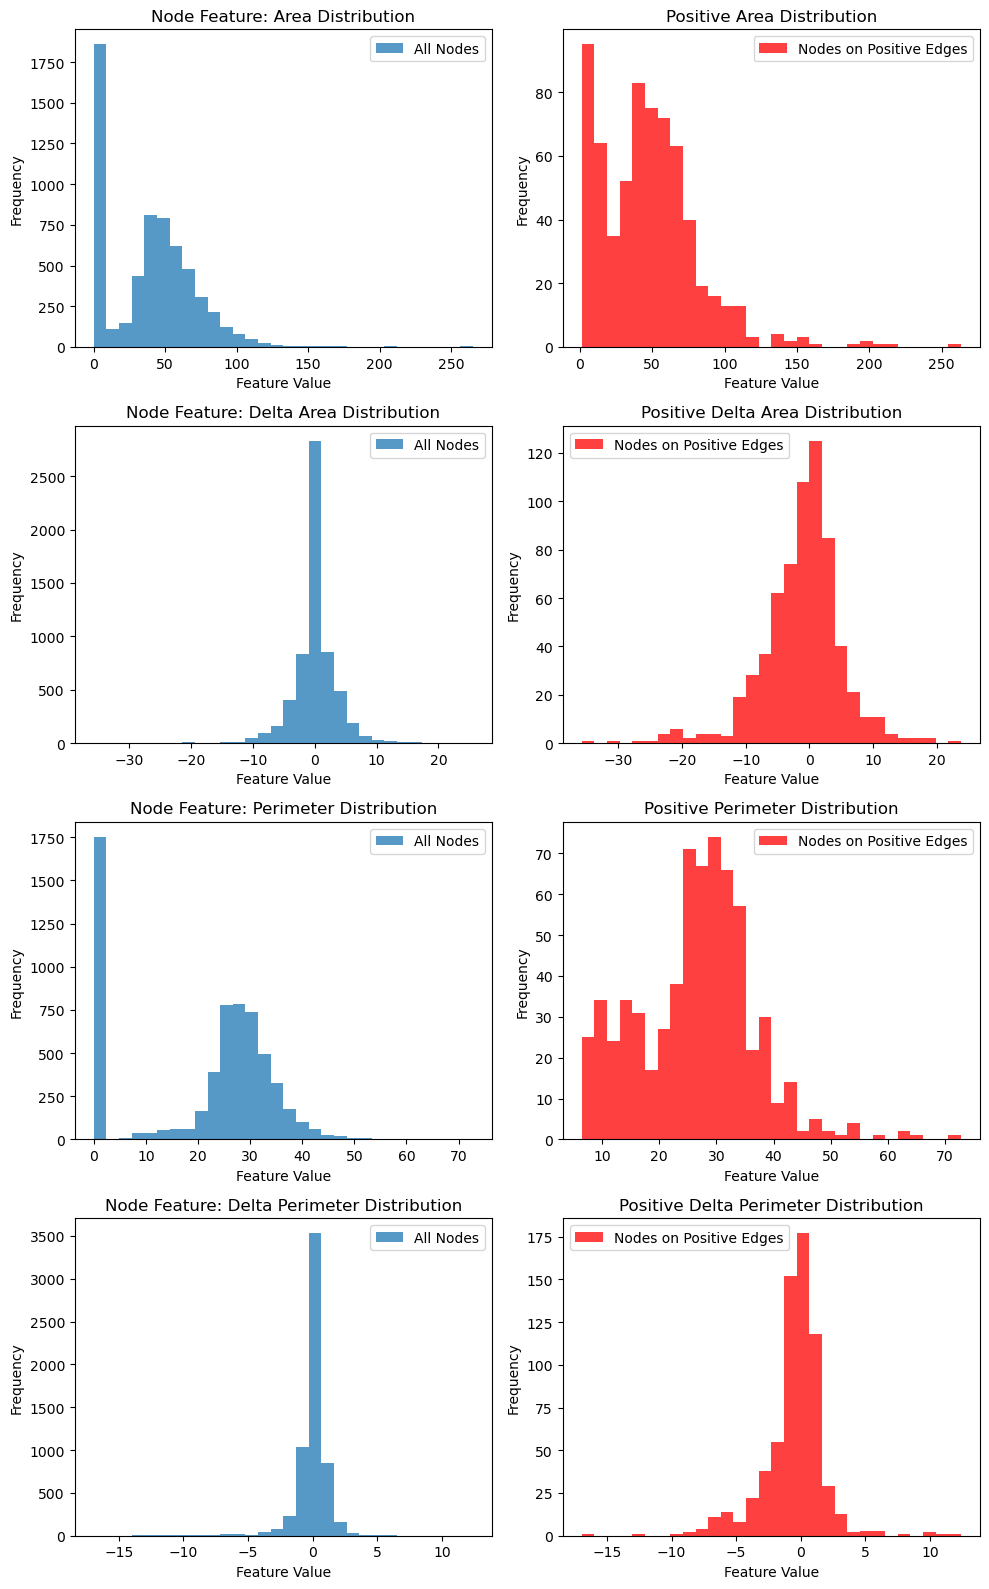

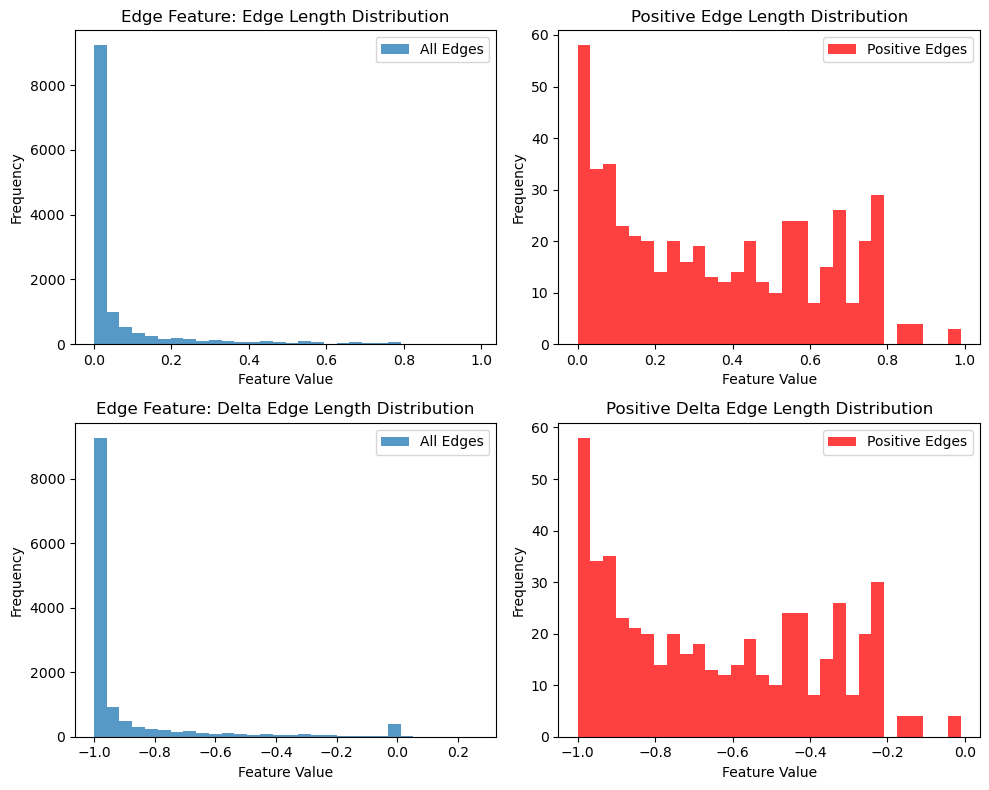

In [11]:
import matplotlib.pyplot as plt

def visualize_data(data_list):
    first_graph = data_list[0]
    num_node_features = first_graph.x.size(1)
    num_edge_features = first_graph.edge_attr.size(1)
    
    positive_edges_indices = first_graph.edge_index[:, first_graph.y.squeeze() == 1].flatten()
    unique_positive_nodes = torch.unique(positive_edges_indices)
    positive_node_features = first_graph.x[unique_positive_nodes]
    positive_edges_features = first_graph.edge_attr[first_graph.y.squeeze() == 1]

    node_feature_labels = ["Area", "Delta Area", "Perimeter", "Delta Perimeter"]
    edge_feature_labels = ["Edge Length", "Delta Edge Length"]

    # Node features
    fig, axes = plt.subplots(num_node_features, 2, figsize=(10, 4 * num_node_features))
    for i in range(num_node_features):
        all_nodes = first_graph.x[:, i].numpy()
        pos_nodes = positive_node_features[:, i].numpy()

        axes[i, 0].hist(all_nodes, bins=30, alpha=0.75, label='All Nodes')
        axes[i, 0].set_title(f'Node Feature: {node_feature_labels[i]} Distribution')
        axes[i, 0].set_xlabel('Feature Value')
        axes[i, 0].set_ylabel('Frequency')

        axes[i, 1].hist(pos_nodes, bins=30, alpha=0.75, label='Nodes on Positive Edges', color='r')
        axes[i, 1].set_title(f'Positive {node_feature_labels[i]} Distribution')
        axes[i, 1].set_xlabel('Feature Value')
        axes[i, 1].set_ylabel('Frequency')

        axes[i, 0].legend()
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

    # Edge features
    fig, axes = plt.subplots(num_edge_features, 2, figsize=(10, 4 * num_edge_features))
    for i in range(num_edge_features):
        all_edges = first_graph.edge_attr[:, i].numpy()
        pos_edges = positive_edges_features[:, i].numpy()

        axes[i, 0].hist(all_edges, bins=30, alpha=0.75, label='All Edges')
        axes[i, 0].set_title(f'Edge Feature: {edge_feature_labels[i]} Distribution')
        axes[i, 0].set_xlabel('Feature Value')
        axes[i, 0].set_ylabel('Frequency')

        axes[i, 1].hist(pos_edges, bins=30, alpha=0.75, label='Positive Edges', color='r')
        axes[i, 1].set_title(f'Positive {edge_feature_labels[i]} Distribution')
        axes[i, 1].set_xlabel('Feature Value')
        axes[i, 1].set_ylabel('Frequency')

        axes[i, 0].legend()
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

visualize_data(train_data_list)

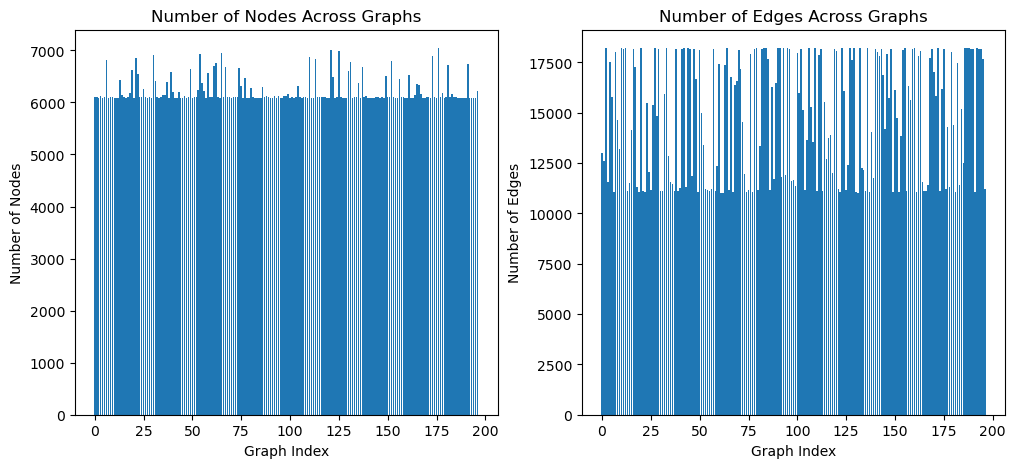

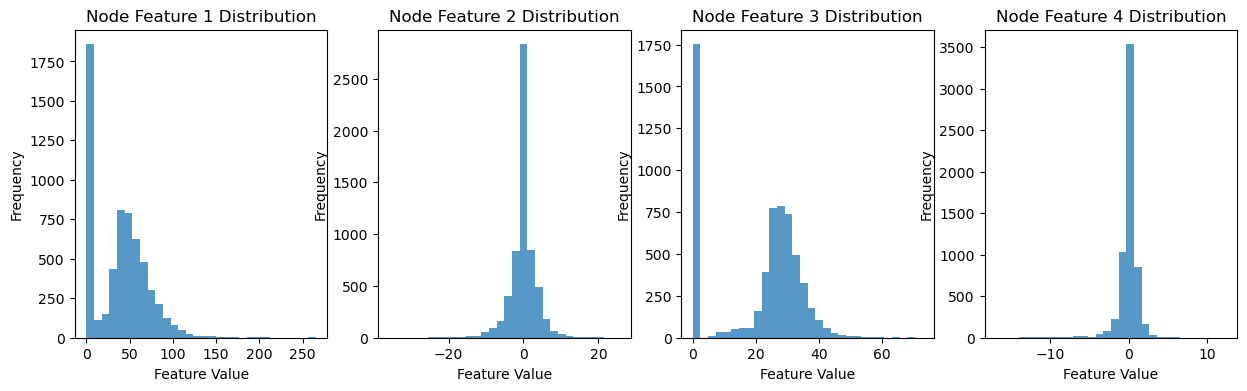

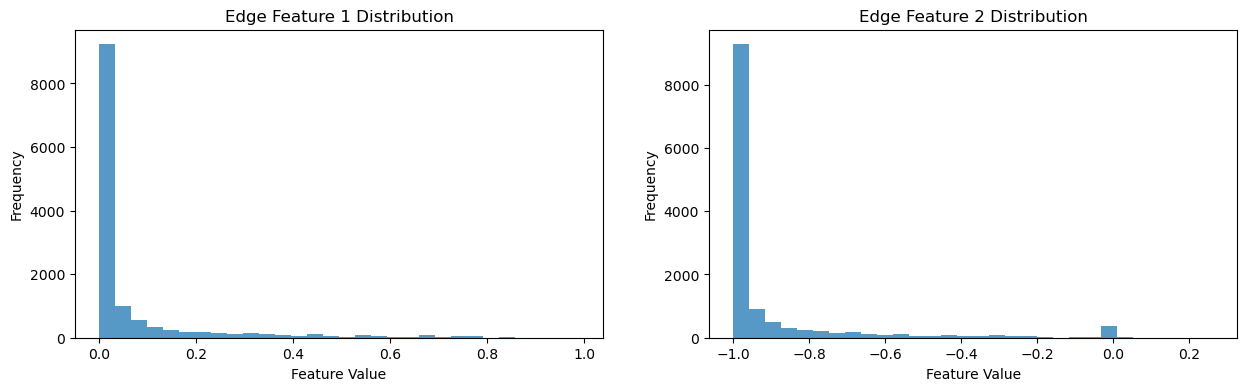

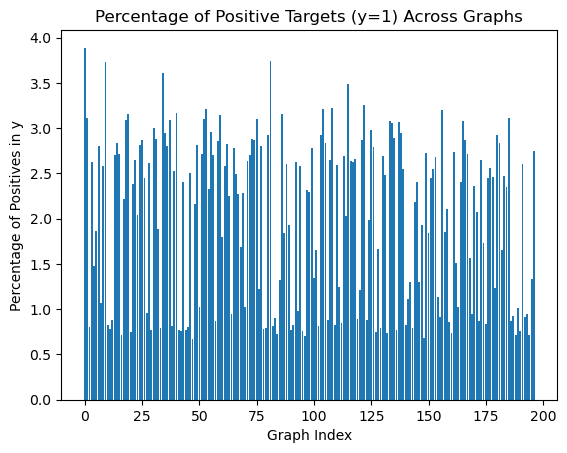

In [12]:
def visualize_data_2(data_list):
    num_nodes = [data.num_nodes for data in data_list]
    num_edges = [data.num_edges for data in data_list]
    y_positives = [(data.y.sum().item() / data.y.size(0)) * 100 for data in data_list] 

    # Plotting number of nodes and edges
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.bar(range(len(num_nodes)), num_nodes)
    plt.title('Number of Nodes Across Graphs')
    plt.xlabel('Graph Index')
    plt.ylabel('Number of Nodes')

    plt.subplot(122)
    plt.bar(range(len(num_edges)), num_edges)
    plt.title('Number of Edges Across Graphs')
    plt.xlabel('Graph Index')
    plt.ylabel('Number of Edges')
    plt.show()

    # Plotting feature distributions for the first graph
    if data_list:
        first_graph = data_list[0]
        num_node_features = first_graph.x.size(1)
        num_edge_features = first_graph.edge_attr.size(1)
        
        # Node features
        fig, axes = plt.subplots(1, num_node_features, figsize=(15, 4))
        for i in range(num_node_features):
            axes[i].hist(first_graph.x[:, i].numpy(), bins=30, alpha=0.75)
            axes[i].set_title(f'Node Feature {i+1} Distribution')
            axes[i].set_xlabel('Feature Value')
            axes[i].set_ylabel('Frequency')

        # Edge features
        fig, axes = plt.subplots(1, num_edge_features, figsize=(15, 4))
        for i in range(num_edge_features):
            axes[i].hist(first_graph.edge_attr[:, i].numpy(), bins=30, alpha=0.75)
            axes[i].set_title(f'Edge Feature {i+1} Distribution')
            axes[i].set_xlabel('Feature Value')
            axes[i].set_ylabel('Frequency')
        plt.show()

    # Plotting percentage of positive y values
    plt.figure()
    plt.bar(range(len(y_positives)), y_positives)
    plt.title('Percentage of Positive Targets (y=1) Across Graphs')
    plt.xlabel('Graph Index')
    plt.ylabel('Percentage of Positives in y')
    plt.show()

visualize_data_2(train_data_list)

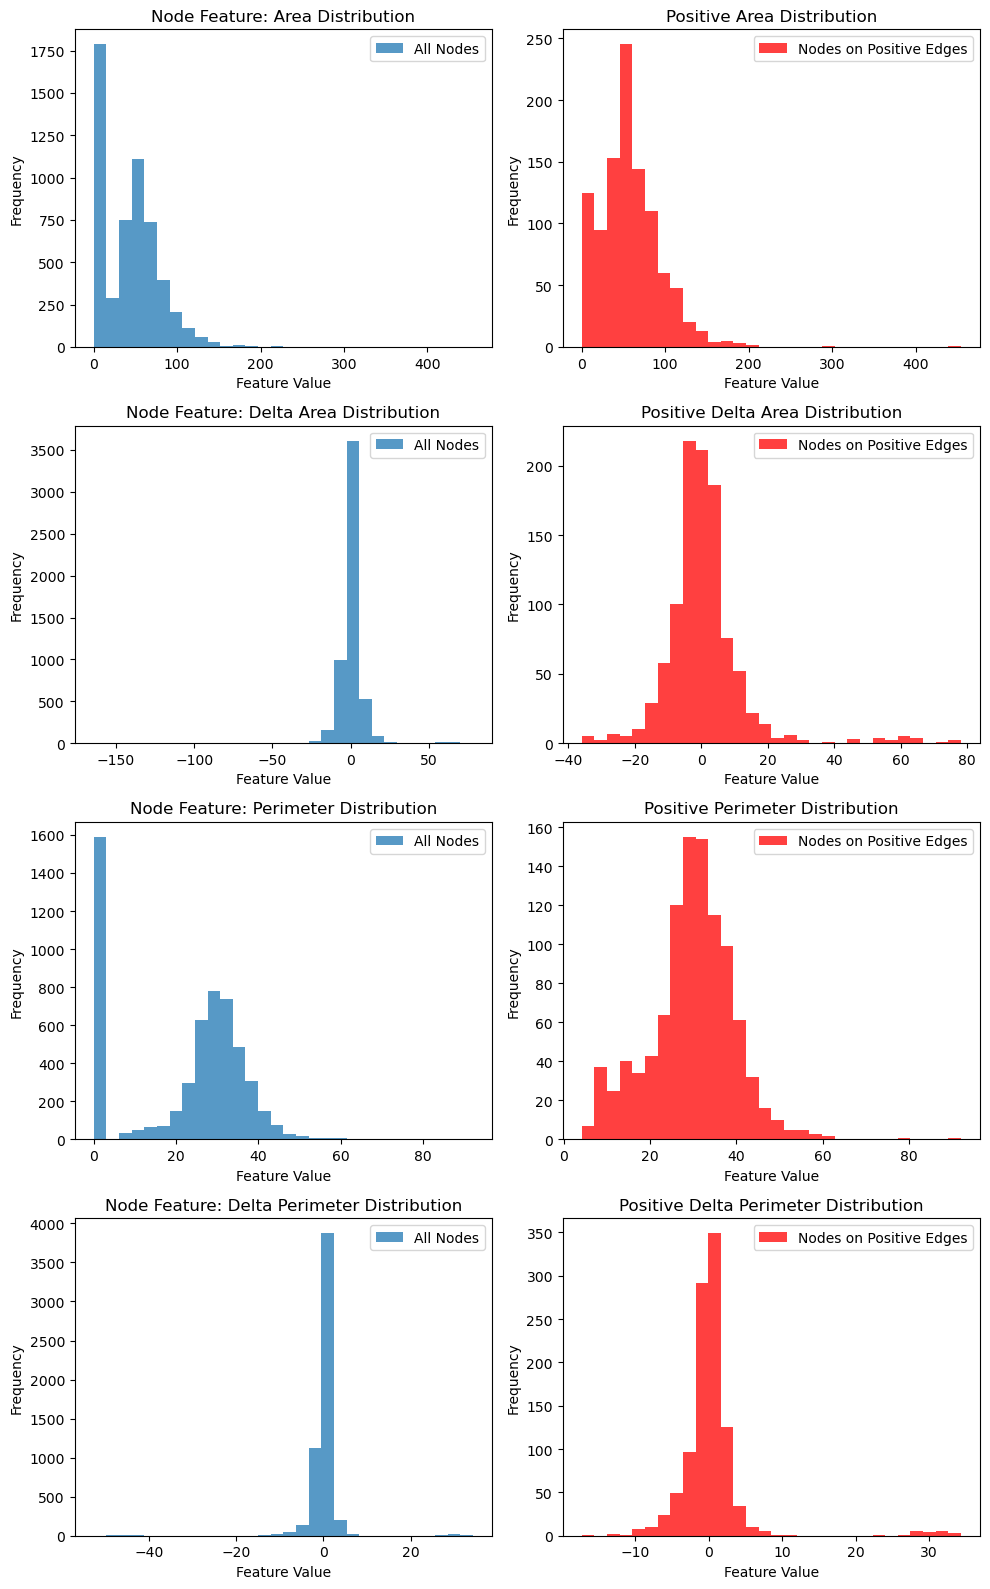

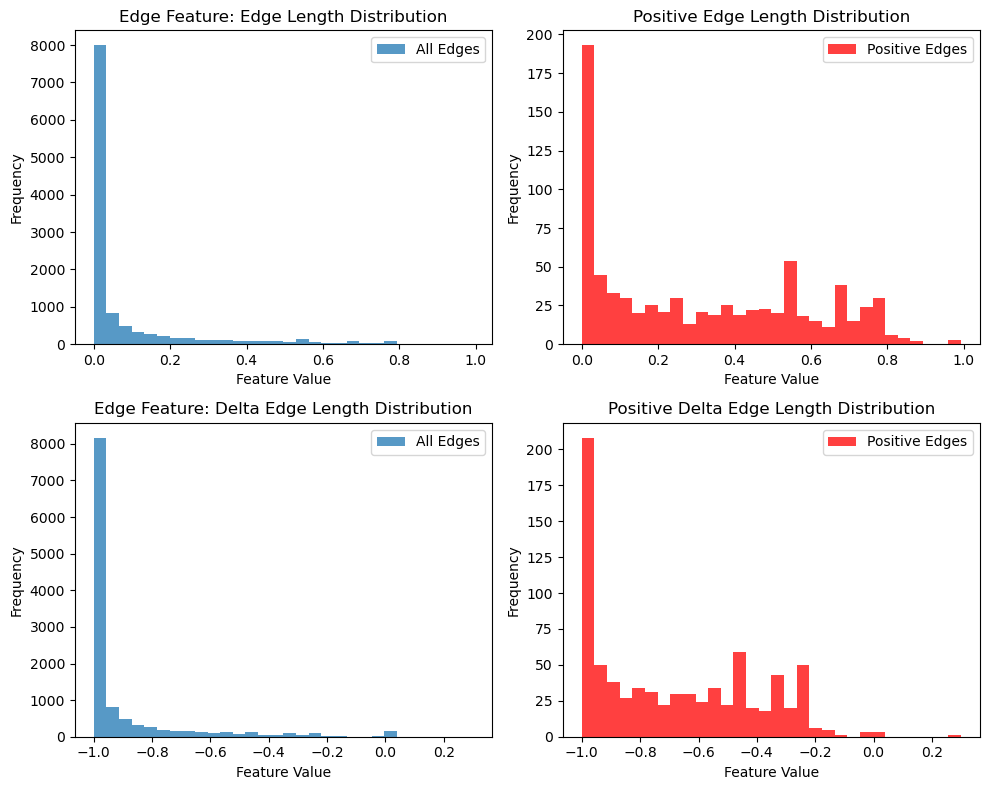

In [13]:
visualize_data(test_data_list)

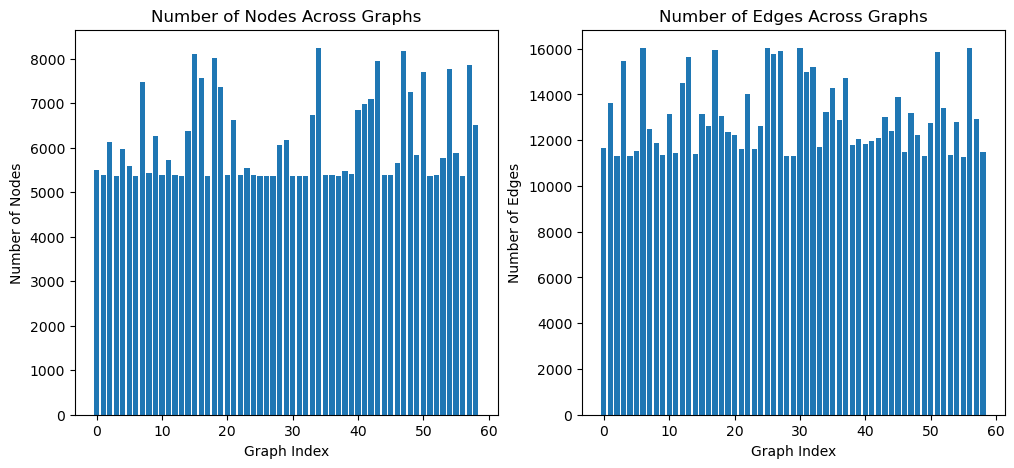

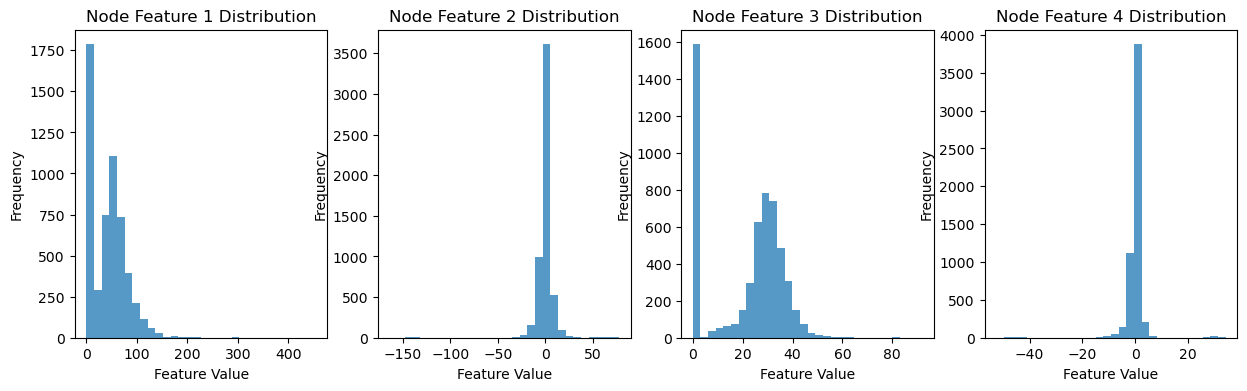

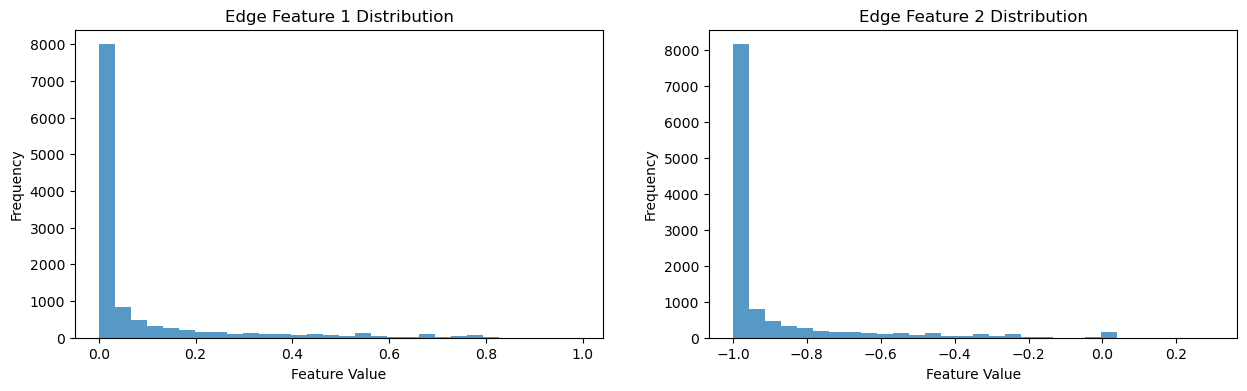

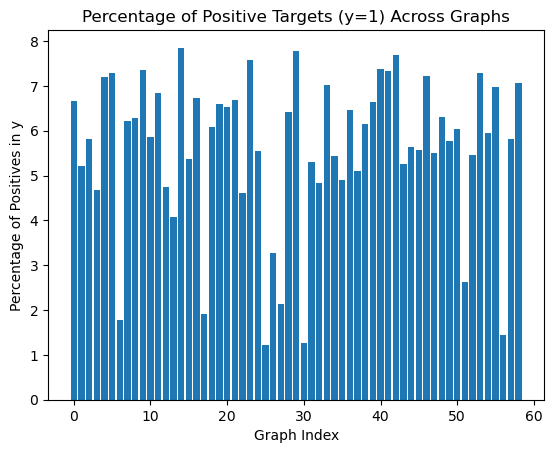

In [14]:
visualize_data_2(test_data_list)

# Model Architecture

In [15]:
import torch
import torch.nn as nn
from torch_geometric.nn import TransformerConv, LayerNorm
from torch_geometric.loader import DataLoader

class GraphTransformerEncoder(nn.Module):
    def __init__(self, c_in_node, c_in_edge, c_hidden=24, num_layers=6, heads=4, dropout=0.5):
        super(GraphTransformerEncoder, self).__init__()

        # Initial TransformerConv layer
        self.initial_conv = TransformerConv(c_in_node, c_hidden // heads, heads=heads, edge_dim=c_in_edge, dropout=dropout)
        self.initial_norm = LayerNorm(c_hidden)

        # Stacked TransformerConv layers
        self.convs = nn.ModuleList([
            TransformerConv(c_hidden, c_hidden // heads, heads=heads, edge_dim=c_in_edge, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.norms = nn.ModuleList([LayerNorm(c_hidden) for _ in range(num_layers)])

        # Final TransformerConv layer
        self.final_conv = TransformerConv(c_hidden, c_hidden // heads, heads=heads, edge_dim=c_in_edge, dropout=dropout)

    def forward(self, x, edge_index, edge_attr):
        # Initial layer with normalization and activation
        x = self.initial_conv(x, edge_index, edge_attr)
        x = self.initial_norm(x)
        x = torch.relu(x)

        # Stacked layers with normalization and activation
        for conv, norm in zip(self.convs, self.norms):
            x = conv(x, edge_index, edge_attr)
            x = norm(x)
            x = torch.relu(x)

        # Final layer
        x = self.final_conv(x, edge_index, edge_attr)
        return x

class InnerProductDecoder(nn.Module):
    def forward(self, z, edge_index):
        edge_embeddings = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(edge_embeddings)

class GraphAutoencoder(nn.Module):
    def __init__(self, c_in_node, c_in_edge, c_hidden=24, num_layers=6, heads=4, dropout=0.5):
        super(GraphAutoencoder, self).__init__()
        self.encoder = GraphTransformerEncoder(c_in_node, c_in_edge, c_hidden, num_layers, heads, dropout)
        self.decoder = InnerProductDecoder()

    def forward(self, x, edge_index, edge_attr):
        # Encoder
        z = self.encoder(x, edge_index, edge_attr)

        # Decoder
        edge_scores = self.decoder(z, edge_index)
        return edge_scores, z

# Train

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
def train_with_regularization(model, train_loader, num_epochs=700, lr=5e-4, weight_decay=1e-8):

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    epoch_losses = []

    model.train() 
    for epoch in range(num_epochs):
        total_loss = 0 

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            x = batch.x.to(device)               
            edge_index = batch.edge_index.to(device)  
            edge_attr = batch.edge_attr.to(device)   
            y = batch.y.to(device)              
            edge_scores, _= model(x, edge_index, edge_attr)
            
            edge_scores = edge_scores.squeeze()
            
            y = y.squeeze(-1)
            
            #print("Shape of edge_scores:", edge_scores.shape)
            #print("Shape of target y:", y.shape)
            
            bce_loss = criterion(edge_scores, y)
            
            e_bar = edge_scores.mean() 
            N_pos = y.sum()  # Number of positive pairs in ground truth
            N_tot = y.size(0)  # Total number of edges
            
            #print(N_pos)
            #print(N_tot)
            regularization_loss = (e_bar - (N_pos / N_tot)) ** 2

            total_batch_loss = bce_loss + regularization_loss

            optimizer.zero_grad()
            total_batch_loss.backward()
            optimizer.step()

            total_loss += total_batch_loss.item()
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {avg_loss:.4f}")

    return epoch_losses

In [26]:
c_in_node = 4  # Node feature dimension (e.g., area, delta_area, perimeter, delta_perimeter)
c_in_edge = 2  # Edge feature dimension (e.g., length, delta_length)
c_hidden = 24  # Hidden dimension for Transformer layers
model = GraphAutoencoder(c_in_node, c_in_edge, c_hidden=c_hidden, num_layers=6, heads=4, dropout=0.5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
train_losses = train_with_regularization(model, train_loader)

Epoch 1/700: 100%|███████████████████████████| 197/197 [00:06<00:00, 29.07it/s]


Epoch 1/700, Total Loss: 2.1717


Epoch 2/700: 100%|███████████████████████████| 197/197 [00:06<00:00, 32.73it/s]


Epoch 2/700, Total Loss: 0.9824


Epoch 3/700: 100%|███████████████████████████| 197/197 [00:05<00:00, 33.72it/s]


Epoch 3/700, Total Loss: 0.9431


Epoch 4/700: 100%|███████████████████████████| 197/197 [00:05<00:00, 34.84it/s]


Epoch 4/700, Total Loss: 0.9121


Epoch 5/700: 100%|███████████████████████████| 197/197 [00:06<00:00, 32.28it/s]


Epoch 5/700, Total Loss: 0.8850


Epoch 6/700: 100%|███████████████████████████| 197/197 [00:06<00:00, 31.01it/s]


Epoch 6/700, Total Loss: 0.8662


Epoch 7/700: 100%|███████████████████████████| 197/197 [00:06<00:00, 29.97it/s]


Epoch 7/700, Total Loss: 0.8498


Epoch 8/700: 100%|███████████████████████████| 197/197 [00:05<00:00, 34.87it/s]


Epoch 8/700, Total Loss: 0.8128


Epoch 9/700: 100%|███████████████████████████| 197/197 [00:05<00:00, 34.63it/s]


Epoch 9/700, Total Loss: 0.7714


Epoch 10/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 31.95it/s]


Epoch 10/700, Total Loss: 0.7351


Epoch 11/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 31.90it/s]


Epoch 11/700, Total Loss: 0.6937


Epoch 12/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.13it/s]


Epoch 12/700, Total Loss: 0.6388


Epoch 13/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 32.45it/s]


Epoch 13/700, Total Loss: 0.5530


Epoch 14/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.74it/s]


Epoch 14/700, Total Loss: 0.4667


Epoch 15/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 29.69it/s]


Epoch 15/700, Total Loss: 0.4103


Epoch 16/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 31.03it/s]


Epoch 16/700, Total Loss: 0.3735


Epoch 17/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.71it/s]


Epoch 17/700, Total Loss: 0.3481


Epoch 18/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.51it/s]


Epoch 18/700, Total Loss: 0.3267


Epoch 19/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.67it/s]


Epoch 19/700, Total Loss: 0.3110


Epoch 20/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.22it/s]


Epoch 20/700, Total Loss: 0.2963


Epoch 21/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 31.47it/s]


Epoch 21/700, Total Loss: 0.2833


Epoch 22/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 31.99it/s]


Epoch 22/700, Total Loss: 0.2713


Epoch 23/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.93it/s]


Epoch 23/700, Total Loss: 0.2592


Epoch 24/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 32.54it/s]


Epoch 24/700, Total Loss: 0.2519


Epoch 25/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.60it/s]


Epoch 25/700, Total Loss: 0.2450


Epoch 26/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 32.28it/s]


Epoch 26/700, Total Loss: 0.2385


Epoch 27/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.02it/s]


Epoch 27/700, Total Loss: 0.2296


Epoch 28/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.63it/s]


Epoch 28/700, Total Loss: 0.2244


Epoch 29/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.54it/s]


Epoch 29/700, Total Loss: 0.2215


Epoch 30/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.82it/s]


Epoch 30/700, Total Loss: 0.2144


Epoch 31/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.25it/s]


Epoch 31/700, Total Loss: 0.2102


Epoch 32/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 31.75it/s]


Epoch 32/700, Total Loss: 0.2077


Epoch 33/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.55it/s]


Epoch 33/700, Total Loss: 0.2022


Epoch 34/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.96it/s]


Epoch 34/700, Total Loss: 0.1989


Epoch 35/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.08it/s]


Epoch 35/700, Total Loss: 0.1959


Epoch 36/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.33it/s]


Epoch 36/700, Total Loss: 0.1913


Epoch 37/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.11it/s]


Epoch 37/700, Total Loss: 0.1888


Epoch 38/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.27it/s]


Epoch 38/700, Total Loss: 0.1848


Epoch 39/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 32.37it/s]


Epoch 39/700, Total Loss: 0.1827


Epoch 40/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.30it/s]


Epoch 40/700, Total Loss: 0.1809


Epoch 41/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 29.48it/s]


Epoch 41/700, Total Loss: 0.1775


Epoch 42/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 32.01it/s]


Epoch 42/700, Total Loss: 0.1775


Epoch 43/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.38it/s]


Epoch 43/700, Total Loss: 0.1743


Epoch 44/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 32.84it/s]


Epoch 44/700, Total Loss: 0.1704


Epoch 45/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 31.98it/s]


Epoch 45/700, Total Loss: 0.1705


Epoch 46/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.54it/s]


Epoch 46/700, Total Loss: 0.1694


Epoch 47/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.95it/s]


Epoch 47/700, Total Loss: 0.1674


Epoch 48/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.92it/s]


Epoch 48/700, Total Loss: 0.1645


Epoch 49/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.89it/s]


Epoch 49/700, Total Loss: 0.1662


Epoch 50/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.70it/s]


Epoch 50/700, Total Loss: 0.1622


Epoch 51/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.31it/s]


Epoch 51/700, Total Loss: 0.1615


Epoch 52/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.41it/s]


Epoch 52/700, Total Loss: 0.1614


Epoch 53/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.71it/s]


Epoch 53/700, Total Loss: 0.1592


Epoch 54/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.66it/s]


Epoch 54/700, Total Loss: 0.1563


Epoch 55/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.64it/s]


Epoch 55/700, Total Loss: 0.1559


Epoch 56/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.48it/s]


Epoch 56/700, Total Loss: 0.1560


Epoch 57/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 31.91it/s]


Epoch 57/700, Total Loss: 0.1560


Epoch 58/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 32.58it/s]


Epoch 58/700, Total Loss: 0.1516


Epoch 59/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 28.59it/s]


Epoch 59/700, Total Loss: 0.1514


Epoch 60/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.58it/s]


Epoch 60/700, Total Loss: 0.1516


Epoch 61/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.79it/s]


Epoch 61/700, Total Loss: 0.1483


Epoch 62/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.16it/s]


Epoch 62/700, Total Loss: 0.1488


Epoch 63/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.16it/s]


Epoch 63/700, Total Loss: 0.1467


Epoch 64/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 29.88it/s]


Epoch 64/700, Total Loss: 0.1476


Epoch 65/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 31.04it/s]


Epoch 65/700, Total Loss: 0.1460


Epoch 66/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 31.90it/s]


Epoch 66/700, Total Loss: 0.1449


Epoch 67/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.70it/s]


Epoch 67/700, Total Loss: 0.1445


Epoch 68/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.74it/s]


Epoch 68/700, Total Loss: 0.1442


Epoch 69/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.66it/s]


Epoch 69/700, Total Loss: 0.1425


Epoch 70/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.41it/s]


Epoch 70/700, Total Loss: 0.1435


Epoch 71/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 31.74it/s]


Epoch 71/700, Total Loss: 0.1402


Epoch 72/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 32.56it/s]


Epoch 72/700, Total Loss: 0.1415


Epoch 73/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.41it/s]


Epoch 73/700, Total Loss: 0.1396


Epoch 74/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.30it/s]


Epoch 74/700, Total Loss: 0.1381


Epoch 75/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 35.53it/s]


Epoch 75/700, Total Loss: 0.1378


Epoch 76/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.54it/s]


Epoch 76/700, Total Loss: 0.1377


Epoch 77/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.33it/s]


Epoch 77/700, Total Loss: 0.1358


Epoch 78/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.68it/s]


Epoch 78/700, Total Loss: 0.1354


Epoch 79/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.48it/s]


Epoch 79/700, Total Loss: 0.1357


Epoch 80/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.94it/s]


Epoch 80/700, Total Loss: 0.1341


Epoch 81/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.62it/s]


Epoch 81/700, Total Loss: 0.1316


Epoch 82/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.25it/s]


Epoch 82/700, Total Loss: 0.1349


Epoch 83/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.10it/s]


Epoch 83/700, Total Loss: 0.1319


Epoch 84/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.26it/s]


Epoch 84/700, Total Loss: 0.1321


Epoch 85/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.84it/s]


Epoch 85/700, Total Loss: 0.1329


Epoch 86/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 32.41it/s]


Epoch 86/700, Total Loss: 0.1324


Epoch 87/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.03it/s]


Epoch 87/700, Total Loss: 0.1311


Epoch 88/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 30.14it/s]


Epoch 88/700, Total Loss: 0.1310


Epoch 89/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.15it/s]


Epoch 89/700, Total Loss: 0.1316


Epoch 90/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.92it/s]


Epoch 90/700, Total Loss: 0.1293


Epoch 91/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.79it/s]


Epoch 91/700, Total Loss: 0.1288


Epoch 92/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 32.94it/s]


Epoch 92/700, Total Loss: 0.1255


Epoch 93/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 32.79it/s]


Epoch 93/700, Total Loss: 0.1277


Epoch 94/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.73it/s]


Epoch 94/700, Total Loss: 0.1276


Epoch 95/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.77it/s]


Epoch 95/700, Total Loss: 0.1294


Epoch 96/700: 100%|██████████████████████████| 197/197 [00:06<00:00, 30.28it/s]


Epoch 96/700, Total Loss: 0.1283


Epoch 97/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.57it/s]


Epoch 97/700, Total Loss: 0.1282


Epoch 98/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 34.34it/s]


Epoch 98/700, Total Loss: 0.1295


Epoch 99/700: 100%|██████████████████████████| 197/197 [00:05<00:00, 33.74it/s]


Epoch 99/700, Total Loss: 0.1280


Epoch 100/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.98it/s]


Epoch 100/700, Total Loss: 0.1279


Epoch 101/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.25it/s]


Epoch 101/700, Total Loss: 0.1256


Epoch 102/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.60it/s]


Epoch 102/700, Total Loss: 0.1258


Epoch 103/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.76it/s]


Epoch 103/700, Total Loss: 0.1271


Epoch 104/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.97it/s]


Epoch 104/700, Total Loss: 0.1254


Epoch 105/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.57it/s]


Epoch 105/700, Total Loss: 0.1245


Epoch 106/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.95it/s]


Epoch 106/700, Total Loss: 0.1261


Epoch 107/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.98it/s]


Epoch 107/700, Total Loss: 0.1244


Epoch 108/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.54it/s]


Epoch 108/700, Total Loss: 0.1225


Epoch 109/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.52it/s]


Epoch 109/700, Total Loss: 0.1219


Epoch 110/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.71it/s]


Epoch 110/700, Total Loss: 0.1235


Epoch 111/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.97it/s]


Epoch 111/700, Total Loss: 0.1214


Epoch 112/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.17it/s]


Epoch 112/700, Total Loss: 0.1219


Epoch 113/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.63it/s]


Epoch 113/700, Total Loss: 0.1241


Epoch 114/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.53it/s]


Epoch 114/700, Total Loss: 0.1226


Epoch 115/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.87it/s]


Epoch 115/700, Total Loss: 0.1209


Epoch 116/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.45it/s]


Epoch 116/700, Total Loss: 0.1230


Epoch 117/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.14it/s]


Epoch 117/700, Total Loss: 0.1225


Epoch 118/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.23it/s]


Epoch 118/700, Total Loss: 0.1231


Epoch 119/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.44it/s]


Epoch 119/700, Total Loss: 0.1230


Epoch 120/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.08it/s]


Epoch 120/700, Total Loss: 0.1203


Epoch 121/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.53it/s]


Epoch 121/700, Total Loss: 0.1186


Epoch 122/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.43it/s]


Epoch 122/700, Total Loss: 0.1195


Epoch 123/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.74it/s]


Epoch 123/700, Total Loss: 0.1217


Epoch 124/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.89it/s]


Epoch 124/700, Total Loss: 0.1206


Epoch 125/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.24it/s]


Epoch 125/700, Total Loss: 0.1200


Epoch 126/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.27it/s]


Epoch 126/700, Total Loss: 0.1192


Epoch 127/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.90it/s]


Epoch 127/700, Total Loss: 0.1195


Epoch 128/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.85it/s]


Epoch 128/700, Total Loss: 0.1186


Epoch 129/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.64it/s]


Epoch 129/700, Total Loss: 0.1212


Epoch 130/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.75it/s]


Epoch 130/700, Total Loss: 0.1203


Epoch 131/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.94it/s]


Epoch 131/700, Total Loss: 0.1200


Epoch 132/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.35it/s]


Epoch 132/700, Total Loss: 0.1185


Epoch 133/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.19it/s]


Epoch 133/700, Total Loss: 0.1194


Epoch 134/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.64it/s]


Epoch 134/700, Total Loss: 0.1174


Epoch 135/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.56it/s]


Epoch 135/700, Total Loss: 0.1191


Epoch 136/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.21it/s]


Epoch 136/700, Total Loss: 0.1204


Epoch 137/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.32it/s]


Epoch 137/700, Total Loss: 0.1196


Epoch 138/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.63it/s]


Epoch 138/700, Total Loss: 0.1180


Epoch 139/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.95it/s]


Epoch 139/700, Total Loss: 0.1167


Epoch 140/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.24it/s]


Epoch 140/700, Total Loss: 0.1182


Epoch 141/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.80it/s]


Epoch 141/700, Total Loss: 0.1179


Epoch 142/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.38it/s]


Epoch 142/700, Total Loss: 0.1178


Epoch 143/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.16it/s]


Epoch 143/700, Total Loss: 0.1168


Epoch 144/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.32it/s]


Epoch 144/700, Total Loss: 0.1177


Epoch 145/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.33it/s]


Epoch 145/700, Total Loss: 0.1156


Epoch 146/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.33it/s]


Epoch 146/700, Total Loss: 0.1151


Epoch 147/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.67it/s]


Epoch 147/700, Total Loss: 0.1176


Epoch 148/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.82it/s]


Epoch 148/700, Total Loss: 0.1183


Epoch 149/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.94it/s]


Epoch 149/700, Total Loss: 0.1195


Epoch 150/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.77it/s]


Epoch 150/700, Total Loss: 0.1164


Epoch 151/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.58it/s]


Epoch 151/700, Total Loss: 0.1185


Epoch 152/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.05it/s]


Epoch 152/700, Total Loss: 0.1141


Epoch 153/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.57it/s]


Epoch 153/700, Total Loss: 0.1163


Epoch 154/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.69it/s]


Epoch 154/700, Total Loss: 0.1146


Epoch 155/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.88it/s]


Epoch 155/700, Total Loss: 0.1164


Epoch 156/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.14it/s]


Epoch 156/700, Total Loss: 0.1155


Epoch 157/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.40it/s]


Epoch 157/700, Total Loss: 0.1177


Epoch 158/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.52it/s]


Epoch 158/700, Total Loss: 0.1156


Epoch 159/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.49it/s]


Epoch 159/700, Total Loss: 0.1183


Epoch 160/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.88it/s]


Epoch 160/700, Total Loss: 0.1151


Epoch 161/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.31it/s]


Epoch 161/700, Total Loss: 0.1158


Epoch 162/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.92it/s]


Epoch 162/700, Total Loss: 0.1166


Epoch 163/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.01it/s]


Epoch 163/700, Total Loss: 0.1166


Epoch 164/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.39it/s]


Epoch 164/700, Total Loss: 0.1160


Epoch 165/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.31it/s]


Epoch 165/700, Total Loss: 0.1158


Epoch 166/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.77it/s]


Epoch 166/700, Total Loss: 0.1151


Epoch 167/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.09it/s]


Epoch 167/700, Total Loss: 0.1144


Epoch 168/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.06it/s]


Epoch 168/700, Total Loss: 0.1138


Epoch 169/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.99it/s]


Epoch 169/700, Total Loss: 0.1132


Epoch 170/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.91it/s]


Epoch 170/700, Total Loss: 0.1137


Epoch 171/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.44it/s]


Epoch 171/700, Total Loss: 0.1151


Epoch 172/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.65it/s]


Epoch 172/700, Total Loss: 0.1136


Epoch 173/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.20it/s]


Epoch 173/700, Total Loss: 0.1135


Epoch 174/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.75it/s]


Epoch 174/700, Total Loss: 0.1135


Epoch 175/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.36it/s]


Epoch 175/700, Total Loss: 0.1160


Epoch 176/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.68it/s]


Epoch 176/700, Total Loss: 0.1164


Epoch 177/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.39it/s]


Epoch 177/700, Total Loss: 0.1140


Epoch 178/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.45it/s]


Epoch 178/700, Total Loss: 0.1131


Epoch 179/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 28.32it/s]


Epoch 179/700, Total Loss: 0.1152


Epoch 180/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 27.58it/s]


Epoch 180/700, Total Loss: 0.1121


Epoch 181/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.99it/s]


Epoch 181/700, Total Loss: 0.1142


Epoch 182/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.69it/s]


Epoch 182/700, Total Loss: 0.1156


Epoch 183/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.59it/s]


Epoch 183/700, Total Loss: 0.1114


Epoch 184/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.20it/s]


Epoch 184/700, Total Loss: 0.1122


Epoch 185/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.51it/s]


Epoch 185/700, Total Loss: 0.1128


Epoch 186/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.88it/s]


Epoch 186/700, Total Loss: 0.1122


Epoch 187/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.17it/s]


Epoch 187/700, Total Loss: 0.1118


Epoch 188/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.71it/s]


Epoch 188/700, Total Loss: 0.1112


Epoch 189/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.29it/s]


Epoch 189/700, Total Loss: 0.1122


Epoch 190/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.99it/s]


Epoch 190/700, Total Loss: 0.1126


Epoch 191/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.61it/s]


Epoch 191/700, Total Loss: 0.1095


Epoch 192/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.83it/s]


Epoch 192/700, Total Loss: 0.1113


Epoch 193/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.17it/s]


Epoch 193/700, Total Loss: 0.1110


Epoch 194/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.30it/s]


Epoch 194/700, Total Loss: 0.1110


Epoch 195/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.50it/s]


Epoch 195/700, Total Loss: 0.1118


Epoch 196/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 27.24it/s]


Epoch 196/700, Total Loss: 0.1114


Epoch 197/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.32it/s]


Epoch 197/700, Total Loss: 0.1135


Epoch 198/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.08it/s]


Epoch 198/700, Total Loss: 0.1115


Epoch 199/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.42it/s]


Epoch 199/700, Total Loss: 0.1142


Epoch 200/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.83it/s]


Epoch 200/700, Total Loss: 0.1127


Epoch 201/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.28it/s]


Epoch 201/700, Total Loss: 0.1104


Epoch 202/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.16it/s]


Epoch 202/700, Total Loss: 0.1109


Epoch 203/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.37it/s]


Epoch 203/700, Total Loss: 0.1094


Epoch 204/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.73it/s]


Epoch 204/700, Total Loss: 0.1116


Epoch 205/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 27.70it/s]


Epoch 205/700, Total Loss: 0.1114


Epoch 206/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.91it/s]


Epoch 206/700, Total Loss: 0.1082


Epoch 207/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.30it/s]


Epoch 207/700, Total Loss: 0.1091


Epoch 208/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.00it/s]


Epoch 208/700, Total Loss: 0.1098


Epoch 209/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.78it/s]


Epoch 209/700, Total Loss: 0.1115


Epoch 210/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.63it/s]


Epoch 210/700, Total Loss: 0.1081


Epoch 211/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 26.78it/s]


Epoch 211/700, Total Loss: 0.1060


Epoch 212/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.74it/s]


Epoch 212/700, Total Loss: 0.1081


Epoch 213/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.04it/s]


Epoch 213/700, Total Loss: 0.1098


Epoch 214/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.37it/s]


Epoch 214/700, Total Loss: 0.1104


Epoch 215/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.27it/s]


Epoch 215/700, Total Loss: 0.1082


Epoch 216/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.28it/s]


Epoch 216/700, Total Loss: 0.1089


Epoch 217/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.94it/s]


Epoch 217/700, Total Loss: 0.1099


Epoch 218/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.84it/s]


Epoch 218/700, Total Loss: 0.1095


Epoch 219/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.61it/s]


Epoch 219/700, Total Loss: 0.1098


Epoch 220/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.26it/s]


Epoch 220/700, Total Loss: 0.1085


Epoch 221/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.14it/s]


Epoch 221/700, Total Loss: 0.1102


Epoch 222/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.55it/s]


Epoch 222/700, Total Loss: 0.1092


Epoch 223/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.40it/s]


Epoch 223/700, Total Loss: 0.1103


Epoch 224/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.95it/s]


Epoch 224/700, Total Loss: 0.1074


Epoch 225/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.03it/s]


Epoch 225/700, Total Loss: 0.1074


Epoch 226/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.93it/s]


Epoch 226/700, Total Loss: 0.1079


Epoch 227/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.48it/s]


Epoch 227/700, Total Loss: 0.1077


Epoch 228/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.49it/s]


Epoch 228/700, Total Loss: 0.1099


Epoch 229/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.82it/s]


Epoch 229/700, Total Loss: 0.1093


Epoch 230/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.29it/s]


Epoch 230/700, Total Loss: 0.1075


Epoch 231/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.87it/s]


Epoch 231/700, Total Loss: 0.1087


Epoch 232/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.66it/s]


Epoch 232/700, Total Loss: 0.1079


Epoch 233/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.09it/s]


Epoch 233/700, Total Loss: 0.1096


Epoch 234/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.92it/s]


Epoch 234/700, Total Loss: 0.1085


Epoch 235/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.65it/s]


Epoch 235/700, Total Loss: 0.1079


Epoch 236/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.26it/s]


Epoch 236/700, Total Loss: 0.1076


Epoch 237/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.10it/s]


Epoch 237/700, Total Loss: 0.1071


Epoch 238/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.58it/s]


Epoch 238/700, Total Loss: 0.1072


Epoch 239/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.04it/s]


Epoch 239/700, Total Loss: 0.1069


Epoch 240/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.68it/s]


Epoch 240/700, Total Loss: 0.1092


Epoch 241/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.21it/s]


Epoch 241/700, Total Loss: 0.1066


Epoch 242/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.20it/s]


Epoch 242/700, Total Loss: 0.1085


Epoch 243/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.81it/s]


Epoch 243/700, Total Loss: 0.1114


Epoch 244/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.52it/s]


Epoch 244/700, Total Loss: 0.1098


Epoch 245/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.16it/s]


Epoch 245/700, Total Loss: 0.1104


Epoch 246/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.92it/s]


Epoch 246/700, Total Loss: 0.1079


Epoch 247/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.82it/s]


Epoch 247/700, Total Loss: 0.1056


Epoch 248/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.29it/s]


Epoch 248/700, Total Loss: 0.1079


Epoch 249/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.97it/s]


Epoch 249/700, Total Loss: 0.1063


Epoch 250/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.09it/s]


Epoch 250/700, Total Loss: 0.1057


Epoch 251/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 28.70it/s]


Epoch 251/700, Total Loss: 0.1060


Epoch 252/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.90it/s]


Epoch 252/700, Total Loss: 0.1047


Epoch 253/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.06it/s]


Epoch 253/700, Total Loss: 0.1053


Epoch 254/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.60it/s]


Epoch 254/700, Total Loss: 0.1068


Epoch 255/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.46it/s]


Epoch 255/700, Total Loss: 0.1075


Epoch 256/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.36it/s]


Epoch 256/700, Total Loss: 0.1058


Epoch 257/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.01it/s]


Epoch 257/700, Total Loss: 0.1078


Epoch 258/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 28.73it/s]


Epoch 258/700, Total Loss: 0.1094


Epoch 259/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.72it/s]


Epoch 259/700, Total Loss: 0.1083


Epoch 260/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.71it/s]


Epoch 260/700, Total Loss: 0.1080


Epoch 261/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.40it/s]


Epoch 261/700, Total Loss: 0.1069


Epoch 262/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 26.08it/s]


Epoch 262/700, Total Loss: 0.1066


Epoch 263/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.16it/s]


Epoch 263/700, Total Loss: 0.1044


Epoch 264/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 24.86it/s]


Epoch 264/700, Total Loss: 0.1059


Epoch 265/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 26.67it/s]


Epoch 265/700, Total Loss: 0.1046


Epoch 266/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.27it/s]


Epoch 266/700, Total Loss: 0.1049


Epoch 267/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.20it/s]


Epoch 267/700, Total Loss: 0.1053


Epoch 268/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.44it/s]


Epoch 268/700, Total Loss: 0.1075


Epoch 269/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.61it/s]


Epoch 269/700, Total Loss: 0.1055


Epoch 270/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.12it/s]


Epoch 270/700, Total Loss: 0.1075


Epoch 271/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.55it/s]


Epoch 271/700, Total Loss: 0.1062


Epoch 272/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.78it/s]


Epoch 272/700, Total Loss: 0.1059


Epoch 273/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.28it/s]


Epoch 273/700, Total Loss: 0.1047


Epoch 274/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.43it/s]


Epoch 274/700, Total Loss: 0.1041


Epoch 275/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.72it/s]


Epoch 275/700, Total Loss: 0.1050


Epoch 276/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.00it/s]


Epoch 276/700, Total Loss: 0.1055


Epoch 277/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.12it/s]


Epoch 277/700, Total Loss: 0.1061


Epoch 278/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.49it/s]


Epoch 278/700, Total Loss: 0.1052


Epoch 279/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.03it/s]


Epoch 279/700, Total Loss: 0.1085


Epoch 280/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.19it/s]


Epoch 280/700, Total Loss: 0.1043


Epoch 281/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.42it/s]


Epoch 281/700, Total Loss: 0.1057


Epoch 282/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 25.93it/s]


Epoch 282/700, Total Loss: 0.1031


Epoch 283/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.10it/s]


Epoch 283/700, Total Loss: 0.1064


Epoch 284/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.22it/s]


Epoch 284/700, Total Loss: 0.1042


Epoch 285/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.71it/s]


Epoch 285/700, Total Loss: 0.1029


Epoch 286/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.36it/s]


Epoch 286/700, Total Loss: 0.1053


Epoch 287/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.69it/s]


Epoch 287/700, Total Loss: 0.1053


Epoch 288/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.09it/s]


Epoch 288/700, Total Loss: 0.1042


Epoch 289/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.23it/s]


Epoch 289/700, Total Loss: 0.1046


Epoch 290/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.52it/s]


Epoch 290/700, Total Loss: 0.1043


Epoch 291/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.09it/s]


Epoch 291/700, Total Loss: 0.1043


Epoch 292/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.29it/s]


Epoch 292/700, Total Loss: 0.1041


Epoch 293/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.24it/s]


Epoch 293/700, Total Loss: 0.1055


Epoch 294/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.95it/s]


Epoch 294/700, Total Loss: 0.1041


Epoch 295/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.47it/s]


Epoch 295/700, Total Loss: 0.1031


Epoch 296/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.53it/s]


Epoch 296/700, Total Loss: 0.1059


Epoch 297/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.38it/s]


Epoch 297/700, Total Loss: 0.1052


Epoch 298/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.86it/s]


Epoch 298/700, Total Loss: 0.1041


Epoch 299/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.93it/s]


Epoch 299/700, Total Loss: 0.1034


Epoch 300/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.97it/s]


Epoch 300/700, Total Loss: 0.1044


Epoch 301/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.59it/s]


Epoch 301/700, Total Loss: 0.1050


Epoch 302/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.72it/s]


Epoch 302/700, Total Loss: 0.1051


Epoch 303/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.42it/s]


Epoch 303/700, Total Loss: 0.1051


Epoch 304/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.38it/s]


Epoch 304/700, Total Loss: 0.1052


Epoch 305/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.07it/s]


Epoch 305/700, Total Loss: 0.1021


Epoch 306/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.39it/s]


Epoch 306/700, Total Loss: 0.1049


Epoch 307/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.60it/s]


Epoch 307/700, Total Loss: 0.1046


Epoch 308/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.68it/s]


Epoch 308/700, Total Loss: 0.1039


Epoch 309/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.53it/s]


Epoch 309/700, Total Loss: 0.1058


Epoch 310/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.66it/s]


Epoch 310/700, Total Loss: 0.1070


Epoch 311/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.22it/s]


Epoch 311/700, Total Loss: 0.1061


Epoch 312/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.62it/s]


Epoch 312/700, Total Loss: 0.1044


Epoch 313/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.82it/s]


Epoch 313/700, Total Loss: 0.1042


Epoch 314/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.37it/s]


Epoch 314/700, Total Loss: 0.1042


Epoch 315/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.16it/s]


Epoch 315/700, Total Loss: 0.1030


Epoch 316/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.21it/s]


Epoch 316/700, Total Loss: 0.1038


Epoch 317/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.88it/s]


Epoch 317/700, Total Loss: 0.1051


Epoch 318/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.86it/s]


Epoch 318/700, Total Loss: 0.1039


Epoch 319/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.09it/s]


Epoch 319/700, Total Loss: 0.1047


Epoch 320/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.71it/s]


Epoch 320/700, Total Loss: 0.1042


Epoch 321/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.96it/s]


Epoch 321/700, Total Loss: 0.1061


Epoch 322/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 26.46it/s]


Epoch 322/700, Total Loss: 0.1058


Epoch 323/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.49it/s]


Epoch 323/700, Total Loss: 0.1043


Epoch 324/700: 100%|█████████████████████████| 197/197 [00:08<00:00, 24.62it/s]


Epoch 324/700, Total Loss: 0.1022


Epoch 325/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.21it/s]


Epoch 325/700, Total Loss: 0.1016


Epoch 326/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.10it/s]


Epoch 326/700, Total Loss: 0.1022


Epoch 327/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.66it/s]


Epoch 327/700, Total Loss: 0.1046


Epoch 328/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 27.62it/s]


Epoch 328/700, Total Loss: 0.1044


Epoch 329/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.11it/s]


Epoch 329/700, Total Loss: 0.1041


Epoch 330/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.46it/s]


Epoch 330/700, Total Loss: 0.1047


Epoch 331/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 28.06it/s]


Epoch 331/700, Total Loss: 0.1054


Epoch 332/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.33it/s]


Epoch 332/700, Total Loss: 0.1024


Epoch 333/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.90it/s]


Epoch 333/700, Total Loss: 0.1003


Epoch 334/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.59it/s]


Epoch 334/700, Total Loss: 0.1050


Epoch 335/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.11it/s]


Epoch 335/700, Total Loss: 0.1030


Epoch 336/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.65it/s]


Epoch 336/700, Total Loss: 0.1019


Epoch 337/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.07it/s]


Epoch 337/700, Total Loss: 0.1027


Epoch 338/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.36it/s]


Epoch 338/700, Total Loss: 0.1015


Epoch 339/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.10it/s]


Epoch 339/700, Total Loss: 0.1009


Epoch 340/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.90it/s]


Epoch 340/700, Total Loss: 0.1020


Epoch 341/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.53it/s]


Epoch 341/700, Total Loss: 0.1002


Epoch 342/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.60it/s]


Epoch 342/700, Total Loss: 0.1010


Epoch 343/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 27.85it/s]


Epoch 343/700, Total Loss: 0.1007


Epoch 344/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.64it/s]


Epoch 344/700, Total Loss: 0.1052


Epoch 345/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.82it/s]


Epoch 345/700, Total Loss: 0.1023


Epoch 346/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.96it/s]


Epoch 346/700, Total Loss: 0.1012


Epoch 347/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.30it/s]


Epoch 347/700, Total Loss: 0.1025


Epoch 348/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.99it/s]


Epoch 348/700, Total Loss: 0.1017


Epoch 349/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.68it/s]


Epoch 349/700, Total Loss: 0.1023


Epoch 350/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.50it/s]


Epoch 350/700, Total Loss: 0.1050


Epoch 351/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.36it/s]


Epoch 351/700, Total Loss: 0.1036


Epoch 352/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.18it/s]


Epoch 352/700, Total Loss: 0.1034


Epoch 353/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.90it/s]


Epoch 353/700, Total Loss: 0.1040


Epoch 354/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.74it/s]


Epoch 354/700, Total Loss: 0.1044


Epoch 355/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.23it/s]


Epoch 355/700, Total Loss: 0.1040


Epoch 356/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.89it/s]


Epoch 356/700, Total Loss: 0.1038


Epoch 357/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.76it/s]


Epoch 357/700, Total Loss: 0.1051


Epoch 358/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.25it/s]


Epoch 358/700, Total Loss: 0.1032


Epoch 359/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.08it/s]


Epoch 359/700, Total Loss: 0.1023


Epoch 360/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.17it/s]


Epoch 360/700, Total Loss: 0.1031


Epoch 361/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.36it/s]


Epoch 361/700, Total Loss: 0.1024


Epoch 362/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.25it/s]


Epoch 362/700, Total Loss: 0.1037


Epoch 363/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 27.74it/s]


Epoch 363/700, Total Loss: 0.1003


Epoch 364/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 27.52it/s]


Epoch 364/700, Total Loss: 0.1045


Epoch 365/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.09it/s]


Epoch 365/700, Total Loss: 0.1056


Epoch 366/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.14it/s]


Epoch 366/700, Total Loss: 0.1027


Epoch 367/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.22it/s]


Epoch 367/700, Total Loss: 0.1033


Epoch 368/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.83it/s]


Epoch 368/700, Total Loss: 0.1035


Epoch 369/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 27.87it/s]


Epoch 369/700, Total Loss: 0.1020


Epoch 370/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.03it/s]


Epoch 370/700, Total Loss: 0.1007


Epoch 371/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.76it/s]


Epoch 371/700, Total Loss: 0.1018


Epoch 372/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.81it/s]


Epoch 372/700, Total Loss: 0.1028


Epoch 373/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.17it/s]


Epoch 373/700, Total Loss: 0.1007


Epoch 374/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.11it/s]


Epoch 374/700, Total Loss: 0.1019


Epoch 375/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.70it/s]


Epoch 375/700, Total Loss: 0.1010


Epoch 376/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.97it/s]


Epoch 376/700, Total Loss: 0.0993


Epoch 377/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.73it/s]


Epoch 377/700, Total Loss: 0.1005


Epoch 378/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.59it/s]


Epoch 378/700, Total Loss: 0.1016


Epoch 379/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.15it/s]


Epoch 379/700, Total Loss: 0.1014


Epoch 380/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.64it/s]


Epoch 380/700, Total Loss: 0.1039


Epoch 381/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.47it/s]


Epoch 381/700, Total Loss: 0.0998


Epoch 382/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.90it/s]


Epoch 382/700, Total Loss: 0.0999


Epoch 383/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.77it/s]


Epoch 383/700, Total Loss: 0.1004


Epoch 384/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.78it/s]


Epoch 384/700, Total Loss: 0.0987


Epoch 385/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.15it/s]


Epoch 385/700, Total Loss: 0.1006


Epoch 386/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.88it/s]


Epoch 386/700, Total Loss: 0.0995


Epoch 387/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.73it/s]


Epoch 387/700, Total Loss: 0.0987


Epoch 388/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.60it/s]


Epoch 388/700, Total Loss: 0.1020


Epoch 389/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.65it/s]


Epoch 389/700, Total Loss: 0.1019


Epoch 390/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.12it/s]


Epoch 390/700, Total Loss: 0.1020


Epoch 391/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.32it/s]


Epoch 391/700, Total Loss: 0.1000


Epoch 392/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.65it/s]


Epoch 392/700, Total Loss: 0.0999


Epoch 393/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.42it/s]


Epoch 393/700, Total Loss: 0.1007


Epoch 394/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.64it/s]


Epoch 394/700, Total Loss: 0.1007


Epoch 395/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.56it/s]


Epoch 395/700, Total Loss: 0.1012


Epoch 396/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.83it/s]


Epoch 396/700, Total Loss: 0.1046


Epoch 397/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.54it/s]


Epoch 397/700, Total Loss: 0.1022


Epoch 398/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.36it/s]


Epoch 398/700, Total Loss: 0.1009


Epoch 399/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.59it/s]


Epoch 399/700, Total Loss: 0.1037


Epoch 400/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.94it/s]


Epoch 400/700, Total Loss: 0.1002


Epoch 401/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.10it/s]


Epoch 401/700, Total Loss: 0.0997


Epoch 402/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.89it/s]


Epoch 402/700, Total Loss: 0.0994


Epoch 403/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.83it/s]


Epoch 403/700, Total Loss: 0.1010


Epoch 404/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.53it/s]


Epoch 404/700, Total Loss: 0.1012


Epoch 405/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.09it/s]


Epoch 405/700, Total Loss: 0.1029


Epoch 406/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.28it/s]


Epoch 406/700, Total Loss: 0.1015


Epoch 407/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.44it/s]


Epoch 407/700, Total Loss: 0.1006


Epoch 408/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.87it/s]


Epoch 408/700, Total Loss: 0.0995


Epoch 409/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.10it/s]


Epoch 409/700, Total Loss: 0.1012


Epoch 410/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.70it/s]


Epoch 410/700, Total Loss: 0.1026


Epoch 411/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.89it/s]


Epoch 411/700, Total Loss: 0.0995


Epoch 412/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.95it/s]


Epoch 412/700, Total Loss: 0.1032


Epoch 413/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.13it/s]


Epoch 413/700, Total Loss: 0.1012


Epoch 414/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.72it/s]


Epoch 414/700, Total Loss: 0.1014


Epoch 415/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.86it/s]


Epoch 415/700, Total Loss: 0.1001


Epoch 416/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.68it/s]


Epoch 416/700, Total Loss: 0.1024


Epoch 417/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.64it/s]


Epoch 417/700, Total Loss: 0.1012


Epoch 418/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.70it/s]


Epoch 418/700, Total Loss: 0.1005


Epoch 419/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.54it/s]


Epoch 419/700, Total Loss: 0.1010


Epoch 420/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.48it/s]


Epoch 420/700, Total Loss: 0.1016


Epoch 421/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.13it/s]


Epoch 421/700, Total Loss: 0.0995


Epoch 422/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.16it/s]


Epoch 422/700, Total Loss: 0.0989


Epoch 423/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.78it/s]


Epoch 423/700, Total Loss: 0.0976


Epoch 424/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.31it/s]


Epoch 424/700, Total Loss: 0.0983


Epoch 425/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.39it/s]


Epoch 425/700, Total Loss: 0.0995


Epoch 426/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.99it/s]


Epoch 426/700, Total Loss: 0.0988


Epoch 427/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.64it/s]


Epoch 427/700, Total Loss: 0.0981


Epoch 428/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.38it/s]


Epoch 428/700, Total Loss: 0.0990


Epoch 429/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.83it/s]


Epoch 429/700, Total Loss: 0.1007


Epoch 430/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.13it/s]


Epoch 430/700, Total Loss: 0.0999


Epoch 431/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.37it/s]


Epoch 431/700, Total Loss: 0.1010


Epoch 432/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.80it/s]


Epoch 432/700, Total Loss: 0.1013


Epoch 433/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.56it/s]


Epoch 433/700, Total Loss: 0.0982


Epoch 434/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.73it/s]


Epoch 434/700, Total Loss: 0.0984


Epoch 435/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.75it/s]


Epoch 435/700, Total Loss: 0.1001


Epoch 436/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.39it/s]


Epoch 436/700, Total Loss: 0.0997


Epoch 437/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.52it/s]


Epoch 437/700, Total Loss: 0.1030


Epoch 438/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.92it/s]


Epoch 438/700, Total Loss: 0.0979


Epoch 439/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.13it/s]


Epoch 439/700, Total Loss: 0.1005


Epoch 440/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.41it/s]


Epoch 440/700, Total Loss: 0.0973


Epoch 441/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 28.87it/s]


Epoch 441/700, Total Loss: 0.0987


Epoch 442/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 27.28it/s]


Epoch 442/700, Total Loss: 0.0992


Epoch 443/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.33it/s]


Epoch 443/700, Total Loss: 0.0987


Epoch 444/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.48it/s]


Epoch 444/700, Total Loss: 0.0985


Epoch 445/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.66it/s]


Epoch 445/700, Total Loss: 0.0981


Epoch 446/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 28.80it/s]


Epoch 446/700, Total Loss: 0.1000


Epoch 447/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 25.40it/s]


Epoch 447/700, Total Loss: 0.1006


Epoch 448/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 27.69it/s]


Epoch 448/700, Total Loss: 0.0999


Epoch 449/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 25.32it/s]


Epoch 449/700, Total Loss: 0.1020


Epoch 450/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 26.73it/s]


Epoch 450/700, Total Loss: 0.1005


Epoch 451/700: 100%|█████████████████████████| 197/197 [00:09<00:00, 21.63it/s]


Epoch 451/700, Total Loss: 0.0983


Epoch 452/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 26.05it/s]


Epoch 452/700, Total Loss: 0.0997


Epoch 453/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 26.74it/s]


Epoch 453/700, Total Loss: 0.0972


Epoch 454/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 26.24it/s]


Epoch 454/700, Total Loss: 0.0973


Epoch 455/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 27.57it/s]


Epoch 455/700, Total Loss: 0.0994


Epoch 456/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.58it/s]


Epoch 456/700, Total Loss: 0.0992


Epoch 457/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.07it/s]


Epoch 457/700, Total Loss: 0.0995


Epoch 458/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.19it/s]


Epoch 458/700, Total Loss: 0.0995


Epoch 459/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.10it/s]


Epoch 459/700, Total Loss: 0.0978


Epoch 460/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.42it/s]


Epoch 460/700, Total Loss: 0.0988


Epoch 461/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.42it/s]


Epoch 461/700, Total Loss: 0.1016


Epoch 462/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.61it/s]


Epoch 462/700, Total Loss: 0.0984


Epoch 463/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.08it/s]


Epoch 463/700, Total Loss: 0.0996


Epoch 464/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.88it/s]


Epoch 464/700, Total Loss: 0.1000


Epoch 465/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.37it/s]


Epoch 465/700, Total Loss: 0.0982


Epoch 466/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.02it/s]


Epoch 466/700, Total Loss: 0.0989


Epoch 467/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.87it/s]


Epoch 467/700, Total Loss: 0.1000


Epoch 468/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.79it/s]


Epoch 468/700, Total Loss: 0.0993


Epoch 469/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.73it/s]


Epoch 469/700, Total Loss: 0.0983


Epoch 470/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.14it/s]


Epoch 470/700, Total Loss: 0.0997


Epoch 471/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.23it/s]


Epoch 471/700, Total Loss: 0.0998


Epoch 472/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.63it/s]


Epoch 472/700, Total Loss: 0.1013


Epoch 473/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.83it/s]


Epoch 473/700, Total Loss: 0.1027


Epoch 474/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.92it/s]


Epoch 474/700, Total Loss: 0.1017


Epoch 475/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.20it/s]


Epoch 475/700, Total Loss: 0.1019


Epoch 476/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.29it/s]


Epoch 476/700, Total Loss: 0.1011


Epoch 477/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.46it/s]


Epoch 477/700, Total Loss: 0.1008


Epoch 478/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.92it/s]


Epoch 478/700, Total Loss: 0.1018


Epoch 479/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.67it/s]


Epoch 479/700, Total Loss: 0.1023


Epoch 480/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.83it/s]


Epoch 480/700, Total Loss: 0.1003


Epoch 481/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.45it/s]


Epoch 481/700, Total Loss: 0.1007


Epoch 482/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.81it/s]


Epoch 482/700, Total Loss: 0.0988


Epoch 483/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.71it/s]


Epoch 483/700, Total Loss: 0.0985


Epoch 484/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.08it/s]


Epoch 484/700, Total Loss: 0.0999


Epoch 485/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.89it/s]


Epoch 485/700, Total Loss: 0.0994


Epoch 486/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.64it/s]


Epoch 486/700, Total Loss: 0.1010


Epoch 487/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.75it/s]


Epoch 487/700, Total Loss: 0.1009


Epoch 488/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.15it/s]


Epoch 488/700, Total Loss: 0.1026


Epoch 489/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.82it/s]


Epoch 489/700, Total Loss: 0.1013


Epoch 490/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.03it/s]


Epoch 490/700, Total Loss: 0.1002


Epoch 491/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 36.47it/s]


Epoch 491/700, Total Loss: 0.1003


Epoch 492/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.55it/s]


Epoch 492/700, Total Loss: 0.0982


Epoch 493/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.98it/s]


Epoch 493/700, Total Loss: 0.0974


Epoch 494/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.73it/s]


Epoch 494/700, Total Loss: 0.0963


Epoch 495/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.99it/s]


Epoch 495/700, Total Loss: 0.0971


Epoch 496/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.87it/s]


Epoch 496/700, Total Loss: 0.0984


Epoch 497/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.25it/s]


Epoch 497/700, Total Loss: 0.0988


Epoch 498/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.14it/s]


Epoch 498/700, Total Loss: 0.0972


Epoch 499/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.24it/s]


Epoch 499/700, Total Loss: 0.0958


Epoch 500/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.88it/s]


Epoch 500/700, Total Loss: 0.0969


Epoch 501/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.50it/s]


Epoch 501/700, Total Loss: 0.0969


Epoch 502/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.71it/s]


Epoch 502/700, Total Loss: 0.0998


Epoch 503/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.11it/s]


Epoch 503/700, Total Loss: 0.0989


Epoch 504/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.70it/s]


Epoch 504/700, Total Loss: 0.0984


Epoch 505/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.20it/s]


Epoch 505/700, Total Loss: 0.0987


Epoch 506/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.37it/s]


Epoch 506/700, Total Loss: 0.1012


Epoch 507/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.99it/s]


Epoch 507/700, Total Loss: 0.1000


Epoch 508/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.88it/s]


Epoch 508/700, Total Loss: 0.0980


Epoch 509/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.89it/s]


Epoch 509/700, Total Loss: 0.0965


Epoch 510/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.71it/s]


Epoch 510/700, Total Loss: 0.0966


Epoch 511/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.84it/s]


Epoch 511/700, Total Loss: 0.0958


Epoch 512/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.94it/s]


Epoch 512/700, Total Loss: 0.0982


Epoch 513/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.27it/s]


Epoch 513/700, Total Loss: 0.0966


Epoch 514/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.71it/s]


Epoch 514/700, Total Loss: 0.0962


Epoch 515/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.28it/s]


Epoch 515/700, Total Loss: 0.0967


Epoch 516/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.37it/s]


Epoch 516/700, Total Loss: 0.0970


Epoch 517/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.72it/s]


Epoch 517/700, Total Loss: 0.0975


Epoch 518/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.38it/s]


Epoch 518/700, Total Loss: 0.1017


Epoch 519/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.01it/s]


Epoch 519/700, Total Loss: 0.0983


Epoch 520/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.24it/s]


Epoch 520/700, Total Loss: 0.0987


Epoch 521/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.07it/s]


Epoch 521/700, Total Loss: 0.0961


Epoch 522/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.65it/s]


Epoch 522/700, Total Loss: 0.0996


Epoch 523/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.90it/s]


Epoch 523/700, Total Loss: 0.0991


Epoch 524/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.71it/s]


Epoch 524/700, Total Loss: 0.0982


Epoch 525/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.80it/s]


Epoch 525/700, Total Loss: 0.1004


Epoch 526/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.22it/s]


Epoch 526/700, Total Loss: 0.0979


Epoch 527/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.68it/s]


Epoch 527/700, Total Loss: 0.0983


Epoch 528/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.84it/s]


Epoch 528/700, Total Loss: 0.0957


Epoch 529/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.99it/s]


Epoch 529/700, Total Loss: 0.0960


Epoch 530/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.23it/s]


Epoch 530/700, Total Loss: 0.0974


Epoch 531/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.64it/s]


Epoch 531/700, Total Loss: 0.0975


Epoch 532/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.58it/s]


Epoch 532/700, Total Loss: 0.0967


Epoch 533/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.39it/s]


Epoch 533/700, Total Loss: 0.0968


Epoch 534/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.85it/s]


Epoch 534/700, Total Loss: 0.0961


Epoch 535/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.65it/s]


Epoch 535/700, Total Loss: 0.0965


Epoch 536/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.96it/s]


Epoch 536/700, Total Loss: 0.0980


Epoch 537/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.11it/s]


Epoch 537/700, Total Loss: 0.0964


Epoch 538/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.65it/s]


Epoch 538/700, Total Loss: 0.0971


Epoch 539/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.29it/s]


Epoch 539/700, Total Loss: 0.0984


Epoch 540/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.22it/s]


Epoch 540/700, Total Loss: 0.0967


Epoch 541/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.15it/s]


Epoch 541/700, Total Loss: 0.0998


Epoch 542/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.41it/s]


Epoch 542/700, Total Loss: 0.0997


Epoch 543/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.34it/s]


Epoch 543/700, Total Loss: 0.0996


Epoch 544/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.91it/s]


Epoch 544/700, Total Loss: 0.1000


Epoch 545/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.24it/s]


Epoch 545/700, Total Loss: 0.0984


Epoch 546/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.16it/s]


Epoch 546/700, Total Loss: 0.0983


Epoch 547/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.64it/s]


Epoch 547/700, Total Loss: 0.1010


Epoch 548/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.19it/s]


Epoch 548/700, Total Loss: 0.1017


Epoch 549/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.70it/s]


Epoch 549/700, Total Loss: 0.1029


Epoch 550/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.84it/s]


Epoch 550/700, Total Loss: 0.0998


Epoch 551/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.45it/s]


Epoch 551/700, Total Loss: 0.0956


Epoch 552/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.41it/s]


Epoch 552/700, Total Loss: 0.0954


Epoch 553/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.74it/s]


Epoch 553/700, Total Loss: 0.0967


Epoch 554/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.10it/s]


Epoch 554/700, Total Loss: 0.0973


Epoch 555/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.81it/s]


Epoch 555/700, Total Loss: 0.0995


Epoch 556/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.30it/s]


Epoch 556/700, Total Loss: 0.0971


Epoch 557/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.39it/s]


Epoch 557/700, Total Loss: 0.0977


Epoch 558/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.49it/s]


Epoch 558/700, Total Loss: 0.0980


Epoch 559/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.60it/s]


Epoch 559/700, Total Loss: 0.0990


Epoch 560/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.70it/s]


Epoch 560/700, Total Loss: 0.0985


Epoch 561/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.58it/s]


Epoch 561/700, Total Loss: 0.0964


Epoch 562/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.68it/s]


Epoch 562/700, Total Loss: 0.0967


Epoch 563/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.91it/s]


Epoch 563/700, Total Loss: 0.0972


Epoch 564/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.14it/s]


Epoch 564/700, Total Loss: 0.0971


Epoch 565/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.63it/s]


Epoch 565/700, Total Loss: 0.0968


Epoch 566/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.88it/s]


Epoch 566/700, Total Loss: 0.0993


Epoch 567/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.21it/s]


Epoch 567/700, Total Loss: 0.0990


Epoch 568/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.75it/s]


Epoch 568/700, Total Loss: 0.0968


Epoch 569/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.56it/s]


Epoch 569/700, Total Loss: 0.0969


Epoch 570/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.16it/s]


Epoch 570/700, Total Loss: 0.1008


Epoch 571/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.94it/s]


Epoch 571/700, Total Loss: 0.1038


Epoch 572/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.55it/s]


Epoch 572/700, Total Loss: 0.1046


Epoch 573/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.84it/s]


Epoch 573/700, Total Loss: 0.1006


Epoch 574/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.71it/s]


Epoch 574/700, Total Loss: 0.0975


Epoch 575/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.14it/s]


Epoch 575/700, Total Loss: 0.0966


Epoch 576/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.54it/s]


Epoch 576/700, Total Loss: 0.0963


Epoch 577/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.60it/s]


Epoch 577/700, Total Loss: 0.0957


Epoch 578/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.76it/s]


Epoch 578/700, Total Loss: 0.0958


Epoch 579/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.45it/s]


Epoch 579/700, Total Loss: 0.0961


Epoch 580/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.55it/s]


Epoch 580/700, Total Loss: 0.0977


Epoch 581/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.78it/s]


Epoch 581/700, Total Loss: 0.0960


Epoch 582/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.80it/s]


Epoch 582/700, Total Loss: 0.0975


Epoch 583/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.90it/s]


Epoch 583/700, Total Loss: 0.0954


Epoch 584/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.39it/s]


Epoch 584/700, Total Loss: 0.0968


Epoch 585/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.20it/s]


Epoch 585/700, Total Loss: 0.0983


Epoch 586/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.29it/s]


Epoch 586/700, Total Loss: 0.0960


Epoch 587/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.11it/s]


Epoch 587/700, Total Loss: 0.0945


Epoch 588/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.61it/s]


Epoch 588/700, Total Loss: 0.0965


Epoch 589/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.47it/s]


Epoch 589/700, Total Loss: 0.0962


Epoch 590/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.83it/s]


Epoch 590/700, Total Loss: 0.0953


Epoch 591/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.16it/s]


Epoch 591/700, Total Loss: 0.0985


Epoch 592/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.88it/s]


Epoch 592/700, Total Loss: 0.0968


Epoch 593/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.13it/s]


Epoch 593/700, Total Loss: 0.0954


Epoch 594/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.56it/s]


Epoch 594/700, Total Loss: 0.0940


Epoch 595/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.21it/s]


Epoch 595/700, Total Loss: 0.0939


Epoch 596/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.98it/s]


Epoch 596/700, Total Loss: 0.0949


Epoch 597/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.51it/s]


Epoch 597/700, Total Loss: 0.0970


Epoch 598/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.73it/s]


Epoch 598/700, Total Loss: 0.0966


Epoch 599/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.49it/s]


Epoch 599/700, Total Loss: 0.0970


Epoch 600/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.64it/s]


Epoch 600/700, Total Loss: 0.0973


Epoch 601/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.99it/s]


Epoch 601/700, Total Loss: 0.0969


Epoch 602/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.89it/s]


Epoch 602/700, Total Loss: 0.0964


Epoch 603/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.33it/s]


Epoch 603/700, Total Loss: 0.0952


Epoch 604/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.71it/s]


Epoch 604/700, Total Loss: 0.0987


Epoch 605/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.36it/s]


Epoch 605/700, Total Loss: 0.0982


Epoch 606/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.11it/s]


Epoch 606/700, Total Loss: 0.0969


Epoch 607/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.28it/s]


Epoch 607/700, Total Loss: 0.0996


Epoch 608/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.15it/s]


Epoch 608/700, Total Loss: 0.1000


Epoch 609/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.45it/s]


Epoch 609/700, Total Loss: 0.0975


Epoch 610/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.92it/s]


Epoch 610/700, Total Loss: 0.0960


Epoch 611/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.93it/s]


Epoch 611/700, Total Loss: 0.0955


Epoch 612/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.74it/s]


Epoch 612/700, Total Loss: 0.0962


Epoch 613/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.63it/s]


Epoch 613/700, Total Loss: 0.0943


Epoch 614/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 28.78it/s]


Epoch 614/700, Total Loss: 0.0937


Epoch 615/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.41it/s]


Epoch 615/700, Total Loss: 0.0945


Epoch 616/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.21it/s]


Epoch 616/700, Total Loss: 0.0944


Epoch 617/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.49it/s]


Epoch 617/700, Total Loss: 0.0951


Epoch 618/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.22it/s]


Epoch 618/700, Total Loss: 0.0977


Epoch 619/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.74it/s]


Epoch 619/700, Total Loss: 0.0960


Epoch 620/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.47it/s]


Epoch 620/700, Total Loss: 0.0951


Epoch 621/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.23it/s]


Epoch 621/700, Total Loss: 0.0960


Epoch 622/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.02it/s]


Epoch 622/700, Total Loss: 0.0949


Epoch 623/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.06it/s]


Epoch 623/700, Total Loss: 0.0949


Epoch 624/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.56it/s]


Epoch 624/700, Total Loss: 0.0964


Epoch 625/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.15it/s]


Epoch 625/700, Total Loss: 0.0977


Epoch 626/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.53it/s]


Epoch 626/700, Total Loss: 0.0950


Epoch 627/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.05it/s]


Epoch 627/700, Total Loss: 0.0984


Epoch 628/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.78it/s]


Epoch 628/700, Total Loss: 0.0967


Epoch 629/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.92it/s]


Epoch 629/700, Total Loss: 0.0965


Epoch 630/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.08it/s]


Epoch 630/700, Total Loss: 0.0972


Epoch 631/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.61it/s]


Epoch 631/700, Total Loss: 0.0985


Epoch 632/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.68it/s]


Epoch 632/700, Total Loss: 0.0994


Epoch 633/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.61it/s]


Epoch 633/700, Total Loss: 0.0999


Epoch 634/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.91it/s]


Epoch 634/700, Total Loss: 0.0990


Epoch 635/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.00it/s]


Epoch 635/700, Total Loss: 0.0969


Epoch 636/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.83it/s]


Epoch 636/700, Total Loss: 0.0992


Epoch 637/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.04it/s]


Epoch 637/700, Total Loss: 0.1005


Epoch 638/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.76it/s]


Epoch 638/700, Total Loss: 0.0986


Epoch 639/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.89it/s]


Epoch 639/700, Total Loss: 0.1017


Epoch 640/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.90it/s]


Epoch 640/700, Total Loss: 0.0978


Epoch 641/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.80it/s]


Epoch 641/700, Total Loss: 0.0968


Epoch 642/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.60it/s]


Epoch 642/700, Total Loss: 0.1013


Epoch 643/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.71it/s]


Epoch 643/700, Total Loss: 0.1014


Epoch 644/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.53it/s]


Epoch 644/700, Total Loss: 0.1003


Epoch 645/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.48it/s]


Epoch 645/700, Total Loss: 0.0966


Epoch 646/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.45it/s]


Epoch 646/700, Total Loss: 0.0975


Epoch 647/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.24it/s]


Epoch 647/700, Total Loss: 0.0970


Epoch 648/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.53it/s]


Epoch 648/700, Total Loss: 0.0976


Epoch 649/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.24it/s]


Epoch 649/700, Total Loss: 0.1014


Epoch 650/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.38it/s]


Epoch 650/700, Total Loss: 0.0994


Epoch 651/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 32.98it/s]


Epoch 651/700, Total Loss: 0.0983


Epoch 652/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.09it/s]


Epoch 652/700, Total Loss: 0.1004


Epoch 653/700: 100%|█████████████████████████| 197/197 [00:07<00:00, 28.02it/s]


Epoch 653/700, Total Loss: 0.1028


Epoch 654/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.44it/s]


Epoch 654/700, Total Loss: 0.1039


Epoch 655/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.03it/s]


Epoch 655/700, Total Loss: 0.1002


Epoch 656/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.44it/s]


Epoch 656/700, Total Loss: 0.1023


Epoch 657/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.26it/s]


Epoch 657/700, Total Loss: 0.1012


Epoch 658/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.62it/s]


Epoch 658/700, Total Loss: 0.0982


Epoch 659/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.43it/s]


Epoch 659/700, Total Loss: 0.0993


Epoch 660/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.92it/s]


Epoch 660/700, Total Loss: 0.0993


Epoch 661/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.92it/s]


Epoch 661/700, Total Loss: 0.0978


Epoch 662/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.48it/s]


Epoch 662/700, Total Loss: 0.0974


Epoch 663/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.95it/s]


Epoch 663/700, Total Loss: 0.0968


Epoch 664/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.13it/s]


Epoch 664/700, Total Loss: 0.0961


Epoch 665/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.00it/s]


Epoch 665/700, Total Loss: 0.0964


Epoch 666/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.31it/s]


Epoch 666/700, Total Loss: 0.0954


Epoch 667/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.32it/s]


Epoch 667/700, Total Loss: 0.0956


Epoch 668/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.44it/s]


Epoch 668/700, Total Loss: 0.0970


Epoch 669/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.65it/s]


Epoch 669/700, Total Loss: 0.0940


Epoch 670/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.25it/s]


Epoch 670/700, Total Loss: 0.0956


Epoch 671/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.72it/s]


Epoch 671/700, Total Loss: 0.0942


Epoch 672/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.40it/s]


Epoch 672/700, Total Loss: 0.0959


Epoch 673/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.47it/s]


Epoch 673/700, Total Loss: 0.0959


Epoch 674/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.44it/s]


Epoch 674/700, Total Loss: 0.0965


Epoch 675/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.71it/s]


Epoch 675/700, Total Loss: 0.0955


Epoch 676/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.42it/s]


Epoch 676/700, Total Loss: 0.0962


Epoch 677/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.56it/s]


Epoch 677/700, Total Loss: 0.0954


Epoch 678/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.93it/s]


Epoch 678/700, Total Loss: 0.0989


Epoch 679/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.71it/s]


Epoch 679/700, Total Loss: 0.1050


Epoch 680/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.61it/s]


Epoch 680/700, Total Loss: 0.1000


Epoch 681/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.16it/s]


Epoch 681/700, Total Loss: 0.0989


Epoch 682/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.07it/s]


Epoch 682/700, Total Loss: 0.0986


Epoch 683/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.14it/s]


Epoch 683/700, Total Loss: 0.0966


Epoch 684/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 30.65it/s]


Epoch 684/700, Total Loss: 0.0960


Epoch 685/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.47it/s]


Epoch 685/700, Total Loss: 0.0954


Epoch 686/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 29.34it/s]


Epoch 686/700, Total Loss: 0.0963


Epoch 687/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 35.22it/s]


Epoch 687/700, Total Loss: 0.0942


Epoch 688/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.83it/s]


Epoch 688/700, Total Loss: 0.0978


Epoch 689/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.85it/s]


Epoch 689/700, Total Loss: 0.0976


Epoch 690/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.57it/s]


Epoch 690/700, Total Loss: 0.0974


Epoch 691/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.26it/s]


Epoch 691/700, Total Loss: 0.0990


Epoch 692/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 32.04it/s]


Epoch 692/700, Total Loss: 0.0983


Epoch 693/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 34.69it/s]


Epoch 693/700, Total Loss: 0.0999


Epoch 694/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.03it/s]


Epoch 694/700, Total Loss: 0.0993


Epoch 695/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.09it/s]


Epoch 695/700, Total Loss: 0.0987


Epoch 696/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.28it/s]


Epoch 696/700, Total Loss: 0.1060


Epoch 697/700: 100%|█████████████████████████| 197/197 [00:05<00:00, 33.92it/s]


Epoch 697/700, Total Loss: 0.1039


Epoch 698/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.59it/s]


Epoch 698/700, Total Loss: 0.1000


Epoch 699/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.82it/s]


Epoch 699/700, Total Loss: 0.1016


Epoch 700/700: 100%|█████████████████████████| 197/197 [00:06<00:00, 31.00it/s]

Epoch 700/700, Total Loss: 0.1006


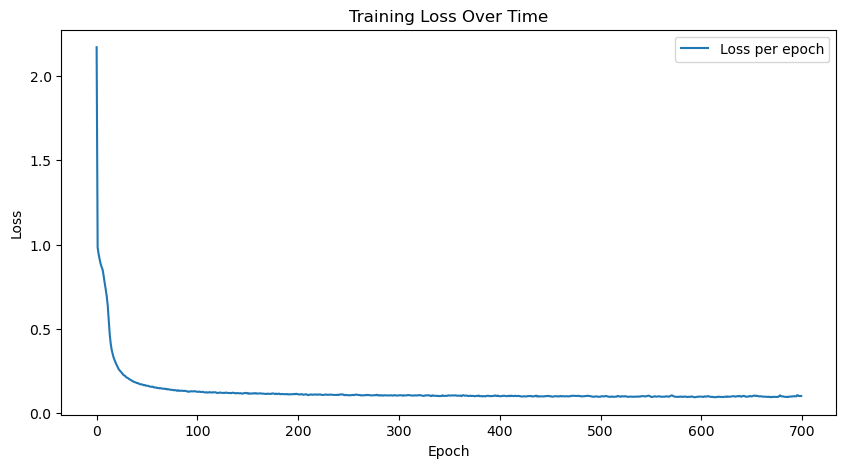

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [ ]:
torch.save({
        'model_state_dict': model.state_dict(),
        'loss': train_losses
    }, save_path)

# Evaluation Function

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
def evaluate_model(model, loader, device):
    model.eval() 
    all_preds = []
    all_targets = []

    with torch.no_grad(): 
        for batch in loader:
            x = batch.x.to(device)                
            edge_index = batch.edge_index.to(device)  
            edge_attr = batch.edge_attr.to(device)    
            y = batch.y.to(device).squeeze(-1)         

            edge_scores, _ = model(x, edge_index, edge_attr)
            edge_scores = edge_scores.squeeze()
    
            predictions = torch.round(edge_scores)  # Threshold at 0.5

            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds, labels=[0, 1])
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)

    # confusion matrix
    fig, ax = plt.subplots()
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greens)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=['Stay', 'Rearrange'], yticklabels=['Stay', 'Rearrange'],
           title='Confusion Matrix', ylabel='Ground truth', xlabel='Prediction')

    fmt = '.2%' 
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm_normalized[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

    return {
        "Confusion Matrix": cm,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

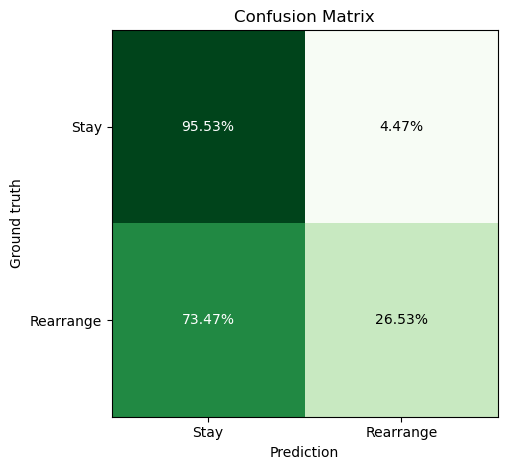

{'Confusion Matrix': array([[696118,  32561],
        [ 30751,  11106]]),
 'Accuracy': 0.9178338195749453,
 'Precision': 0.254333936382165,
 'Recall': 0.2653319635903194,
 'F1 Score': 0.2597165707871475}

In [31]:
evaluate_model(model, test_loader, device)